## Importing required libraries

In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import seaborn as sns
import sqlite3
import matplotlib.pyplot as plt
import scipy.stats as st
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, KFold
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import silhouette_score
pd.set_option('display.max_columns',100)
import warnings
warnings.filterwarnings('ignore')

## Reading the data

In [2]:
# Path to SQLite database
database_path = 'candidate_data.db'

# Create a connection to the SQLite database
conn = sqlite3.connect(database_path)

# SQL query to select all data from the training data table
query_train = "SELECT * FROM train_data"

# Load data from the SQL query into a pandas DataFrame
df_train = pd.read_sql_query(query_train, conn)

# SQL query to select all data from the testing data table
query_test = "SELECT * FROM test_data"

# Load data from the SQL query into a pandas DataFrame
df_test = pd.read_sql_query(query_test, conn)

# Close the connection to the database
conn.close()

## Cleaning Corrected Data

In [3]:
#Cleaning the data
df_train['name'] = df_train['name'].str.replace('\n','')
df_train['name'] = df_train['name'].str.strip()

## Null Value Imputation

In [4]:
df_train['job_role'].fillna('NA',inplace=True)
df_train['tags'].fillna('NA',inplace=True)
df_train['gold_badges'].fillna('NA',inplace=True)
df_train['silver_badges'].fillna('0',inplace=True)
df_train['bronze_badges'].fillna('0',inplace=True)
df_train['questions'].fillna('0',inplace=True)
df_train['answers'].fillna('0',inplace=True)
df_train['reputation'].fillna('0',inplace=True)
df_train['reached'].fillna('0',inplace=True)
df_train['posts_edited'].fillna('0',inplace=True)
df_train['votes_cast'].fillna('0',inplace=True)
df_train['helpful_tags'].fillna('0',inplace=True)

# DATA CLEANING

## 1. Remove , from all numerical columns

In [5]:
df_train[['silver_badges', 'bronze_badges','posts_edited', 'helpful_tags', 'votes_cast', 'reputation','reached', 'answers', 'questions']] = df_train[['silver_badges', 'bronze_badges','posts_edited', 'helpful_tags', 'votes_cast', 'reputation','reached', 'answers', 'questions']].apply(lambda x:x.str.replace(",",""))

## 2. Clean k and m values

In [6]:
df_train['reached'] = df_train['reached'].str.strip()

def convert_k_to_num(value):
    if isinstance(value, str) and value.lower().endswith('k'):
        return float(value[:-1]) * 1000
    elif isinstance(value, str) and value.lower().endswith('m'):
        return float(value[:-1]) * 1000000
    else:
        return float(value)
    
df_train['reached'] = df_train['reached'].apply(convert_k_to_num)

## 3. Cleaning Member_Since

In [7]:
def convert_to_months(s):
    # Initialize years, months, and days
    years, months, days = 0, 0, 0
    
    # Find and convert years, if present
    if 'year' in s:
        years = int(s.split('year')[0].strip())
    
    # Find and convert months, if present
    if 'month' in s:
        months = int(s.split('month')[0].split(',')[-1].strip())
    
    # Find and convert days, if present
    if 'day' in s:
        days = int(s.split('day')[0].split(',')[-1].strip())
    
    # Convert everything to months (approximation)
    total_months = years * 12 + months + days / 30  # Convert days to a fraction of a month
    return total_months

# Apply the conversion function to your 'Member_Since' column
df_train['member_since_in_months'] = df_train['member_since'].apply(convert_to_months)
df_train['member_since_in_months'] = df_train['member_since_in_months'].round(2)

## Type Casting

In [8]:
df_train[['silver_badges', 'bronze_badges','posts_edited', 'helpful_tags', 'votes_cast', 'reputation','reached', 'answers', 'questions']] = df_train[['silver_badges', 'bronze_badges','posts_edited', 'helpful_tags', 'votes_cast', 'reputation','reached', 'answers', 'questions']].apply(pd.to_numeric)

## FEATURE ENGINEERING

## SOLUTIONS ARCHITECT

### Cloud_Services_Flag - 

## Creating flags for all the skills

In [9]:
df_train['weighted_badge_score'] = (3 * df_train['gold_badges']) + (2 * df_train['silver_badges']) + df_train['bronze_badges']
df_train['questions'] = np.where(df_train['questions']==0, 1, df_train['questions'])
df_train['QA_ratio'] = (df_train['answers']/df_train['questions']).round(2)

#dropping this because there's a weighted badge score
df_train.drop(columns=['gold_badges', 'silver_badges', 'bronze_badges'], inplace=True)

In [10]:
df_train['Cloud_Services_Flag'] = np.where(df_train['tags'].str.contains('gcp|amazon|amazon-web-services|gcp|cloud|google-cloud-platform|azure'),1,0)
df_train['DevOps_Flag'] = np.where(df_train['tags'].str.contains('devops|jenkins|docker|kubernetes|ansible|terraform'),1,0)
df_train['Security_Flag'] = np.where(df_train['tags'].str.contains('security|oauth|ssl|encryption|cybersecurity|cyber-security'),1,0)
df_train['total_requirements_satisfied'] = df_train['Cloud_Services_Flag'] + df_train['DevOps_Flag'] + df_train['Security_Flag']

In [11]:
df_train.shape

(34279, 20)

## Shortlisting Solution Architects

In [12]:
df_train = df_train[(df_train['total_requirements_satisfied']>=1)]

In [13]:
df_train.shape

(4180, 20)

## Transformations

REPUTATION 

       Transformation      Skew
               Actual 12.686340
                  Log  0.160906
           Reciprocal  1.516649
Exponential power 0.2  1.116800
Exponential power 0.3  1.848731
          Square Root  3.868803
            Cube Root  2.127517
               Boxcox  0.027031

 Best Transformation for  reputation : 
 Boxcox = 0.027030855758498343


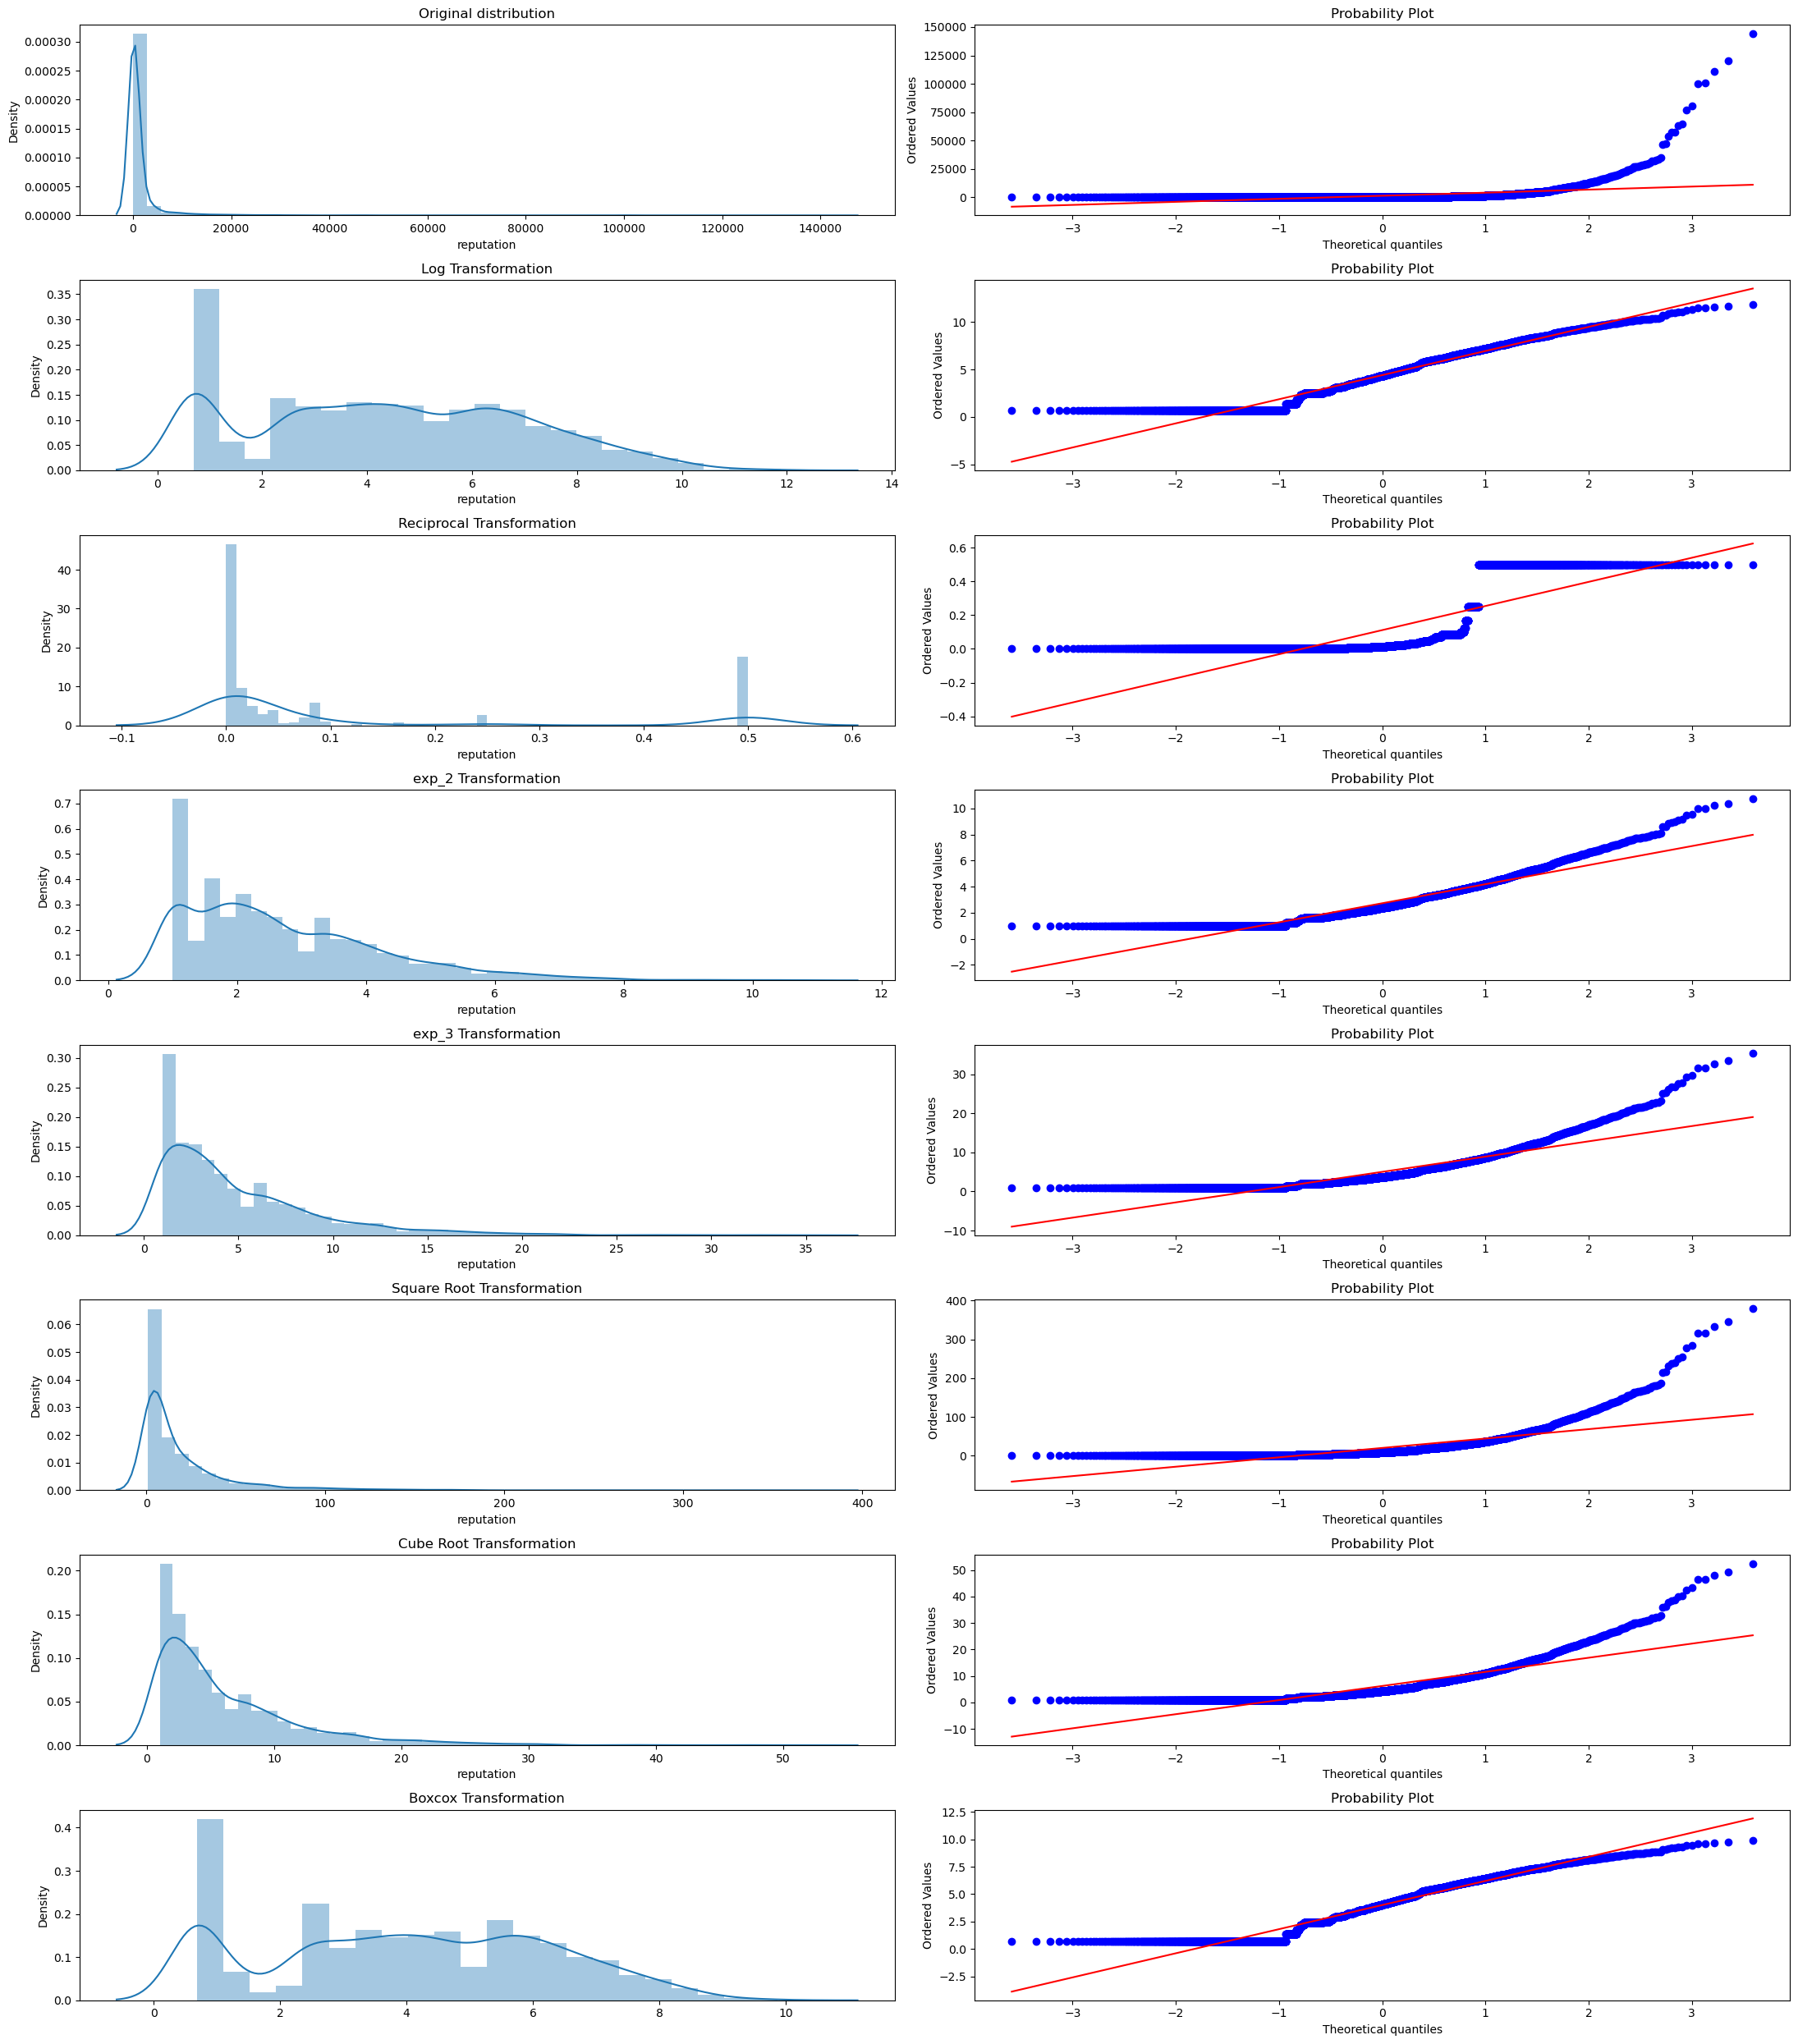

REACHED 

       Transformation      Skew
               Actual  8.524183
                  Log -0.033948
           Reciprocal 22.834146
Exponential power 0.2  1.156762
Exponential power 0.3  1.849950
          Square Root  3.375615
            Cube Root  2.091388
               Boxcox -0.005637

 Best Transformation for  reached : 
 Boxcox = -0.005637143109890289


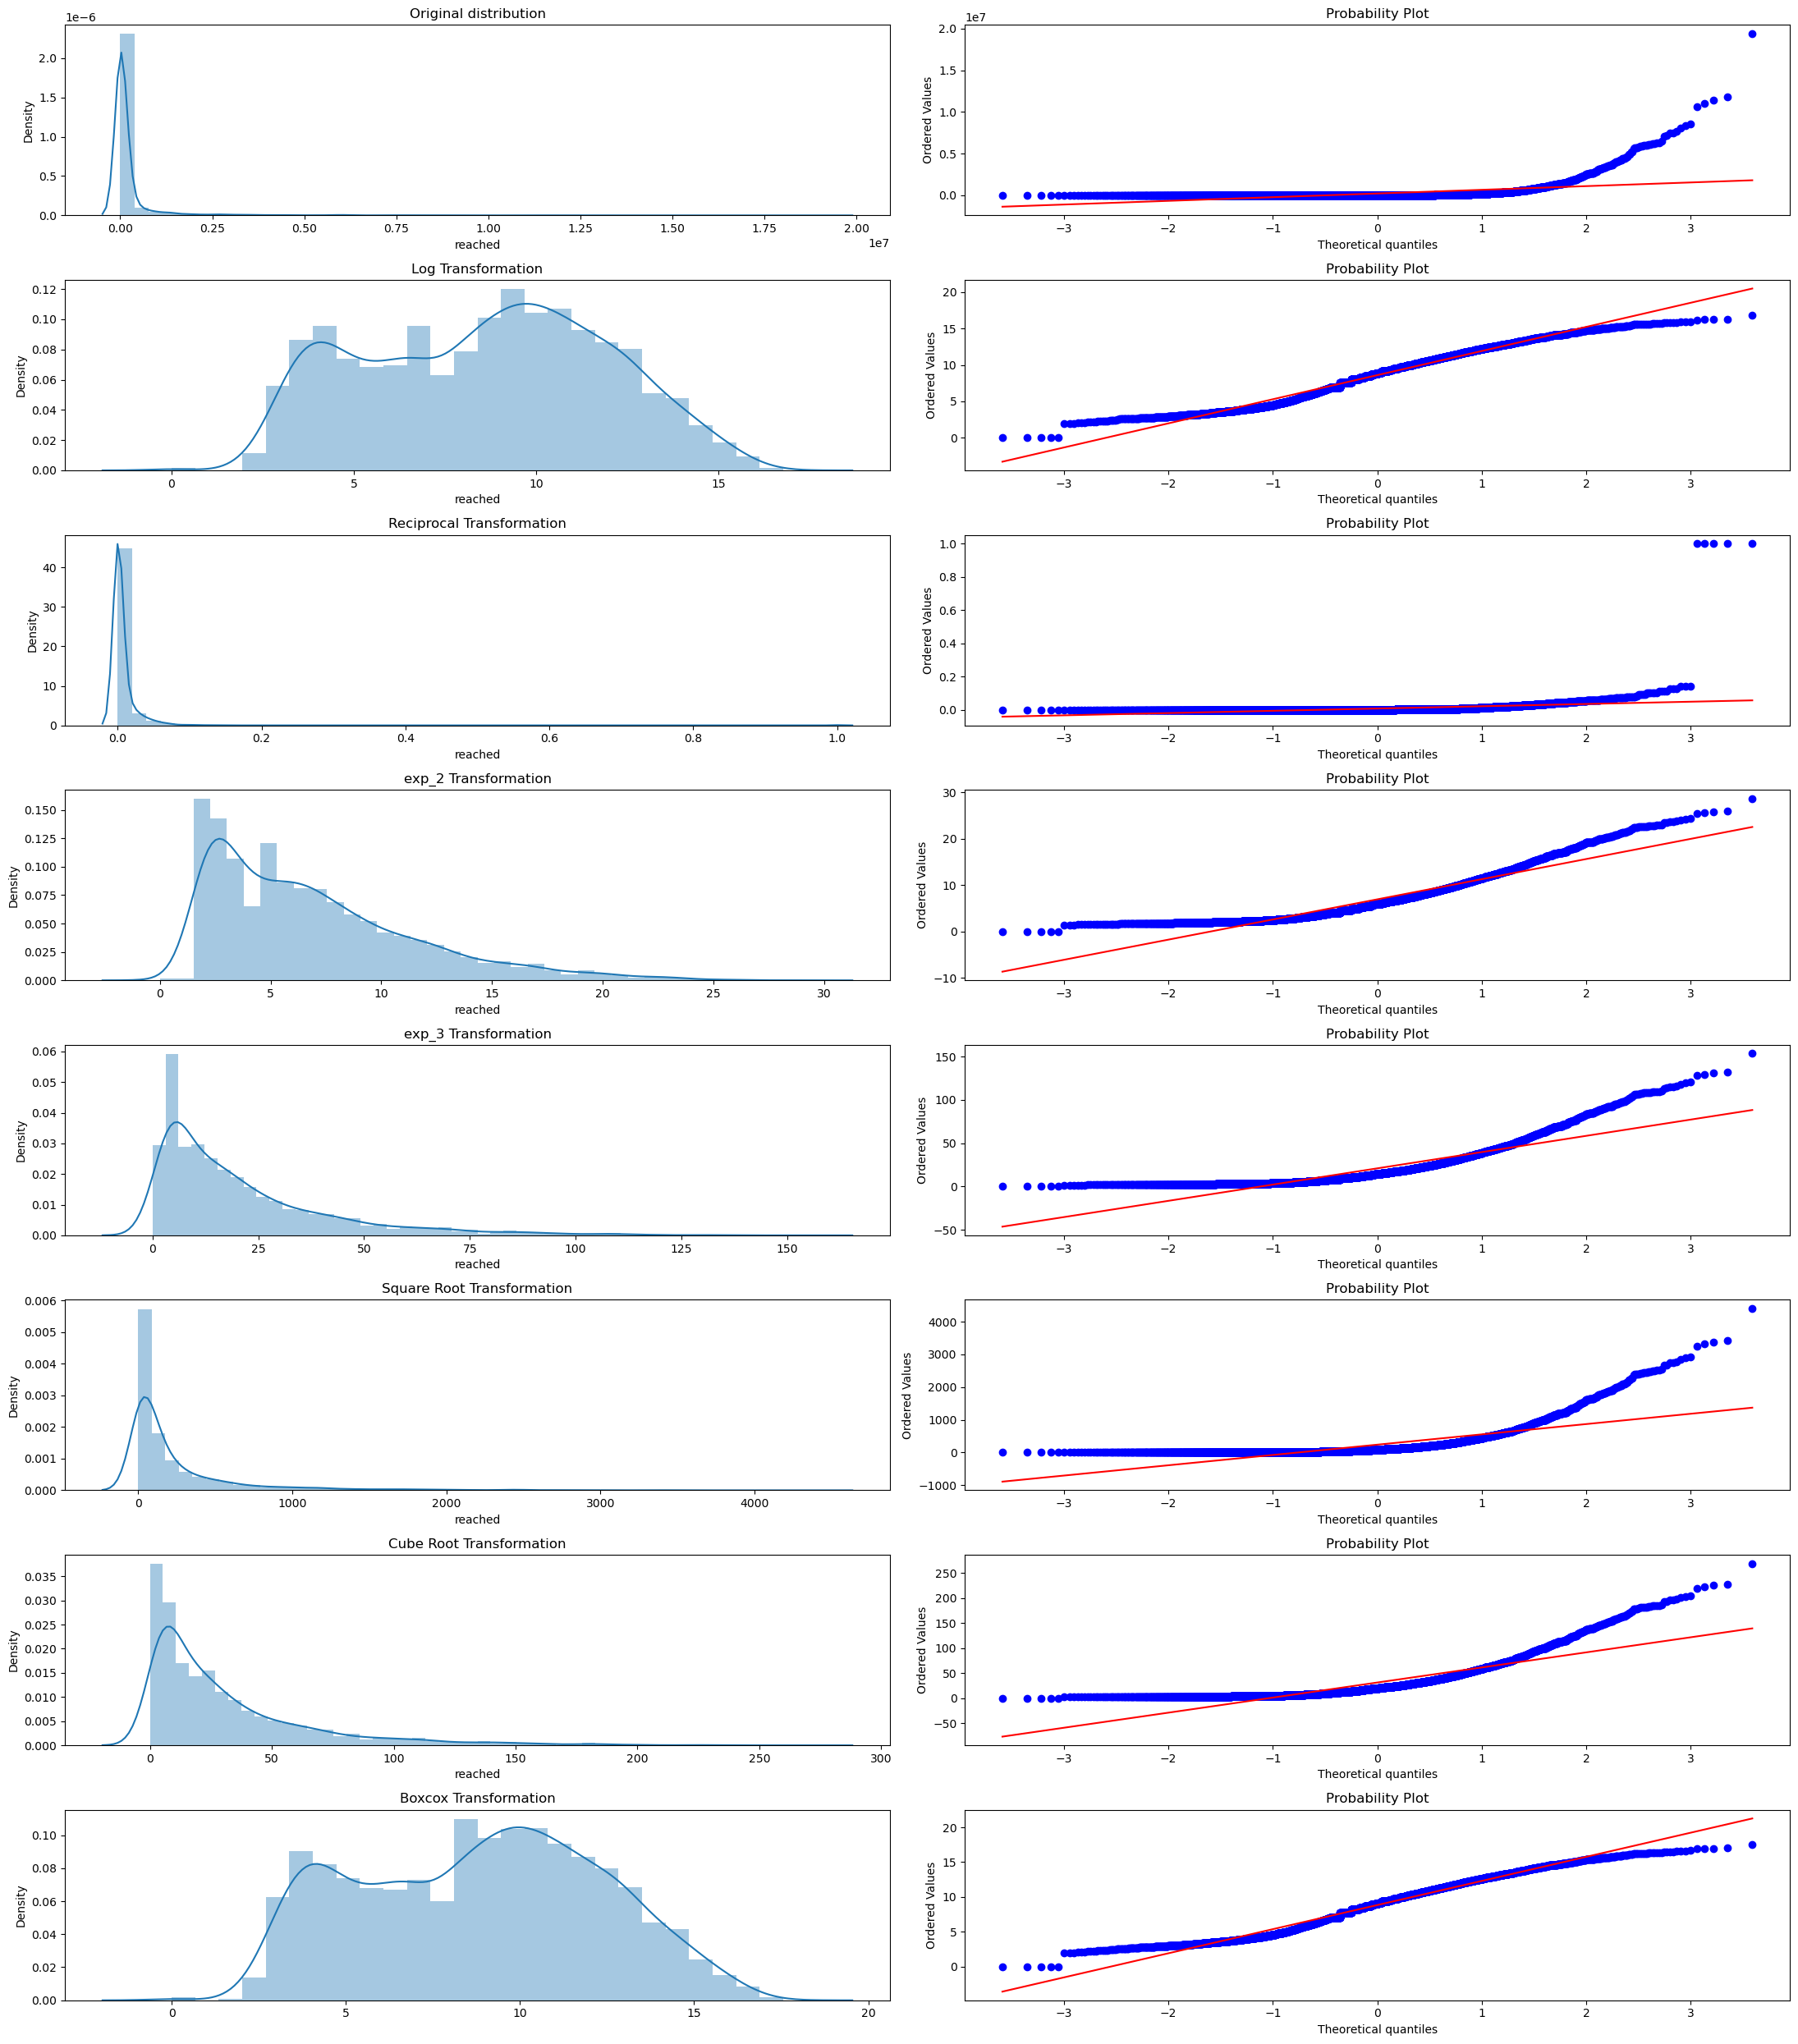

QUESTIONS 

       Transformation     Skew
               Actual 7.525996
                  Log 0.807023
           Reciprocal 0.640734
Exponential power 0.2 1.245996
Exponential power 0.3 1.707848
          Square Root 2.892705
            Cube Root 1.879846
               Boxcox 0.154191

 Best Transformation for  questions : 
 Boxcox = 0.15419120971514533


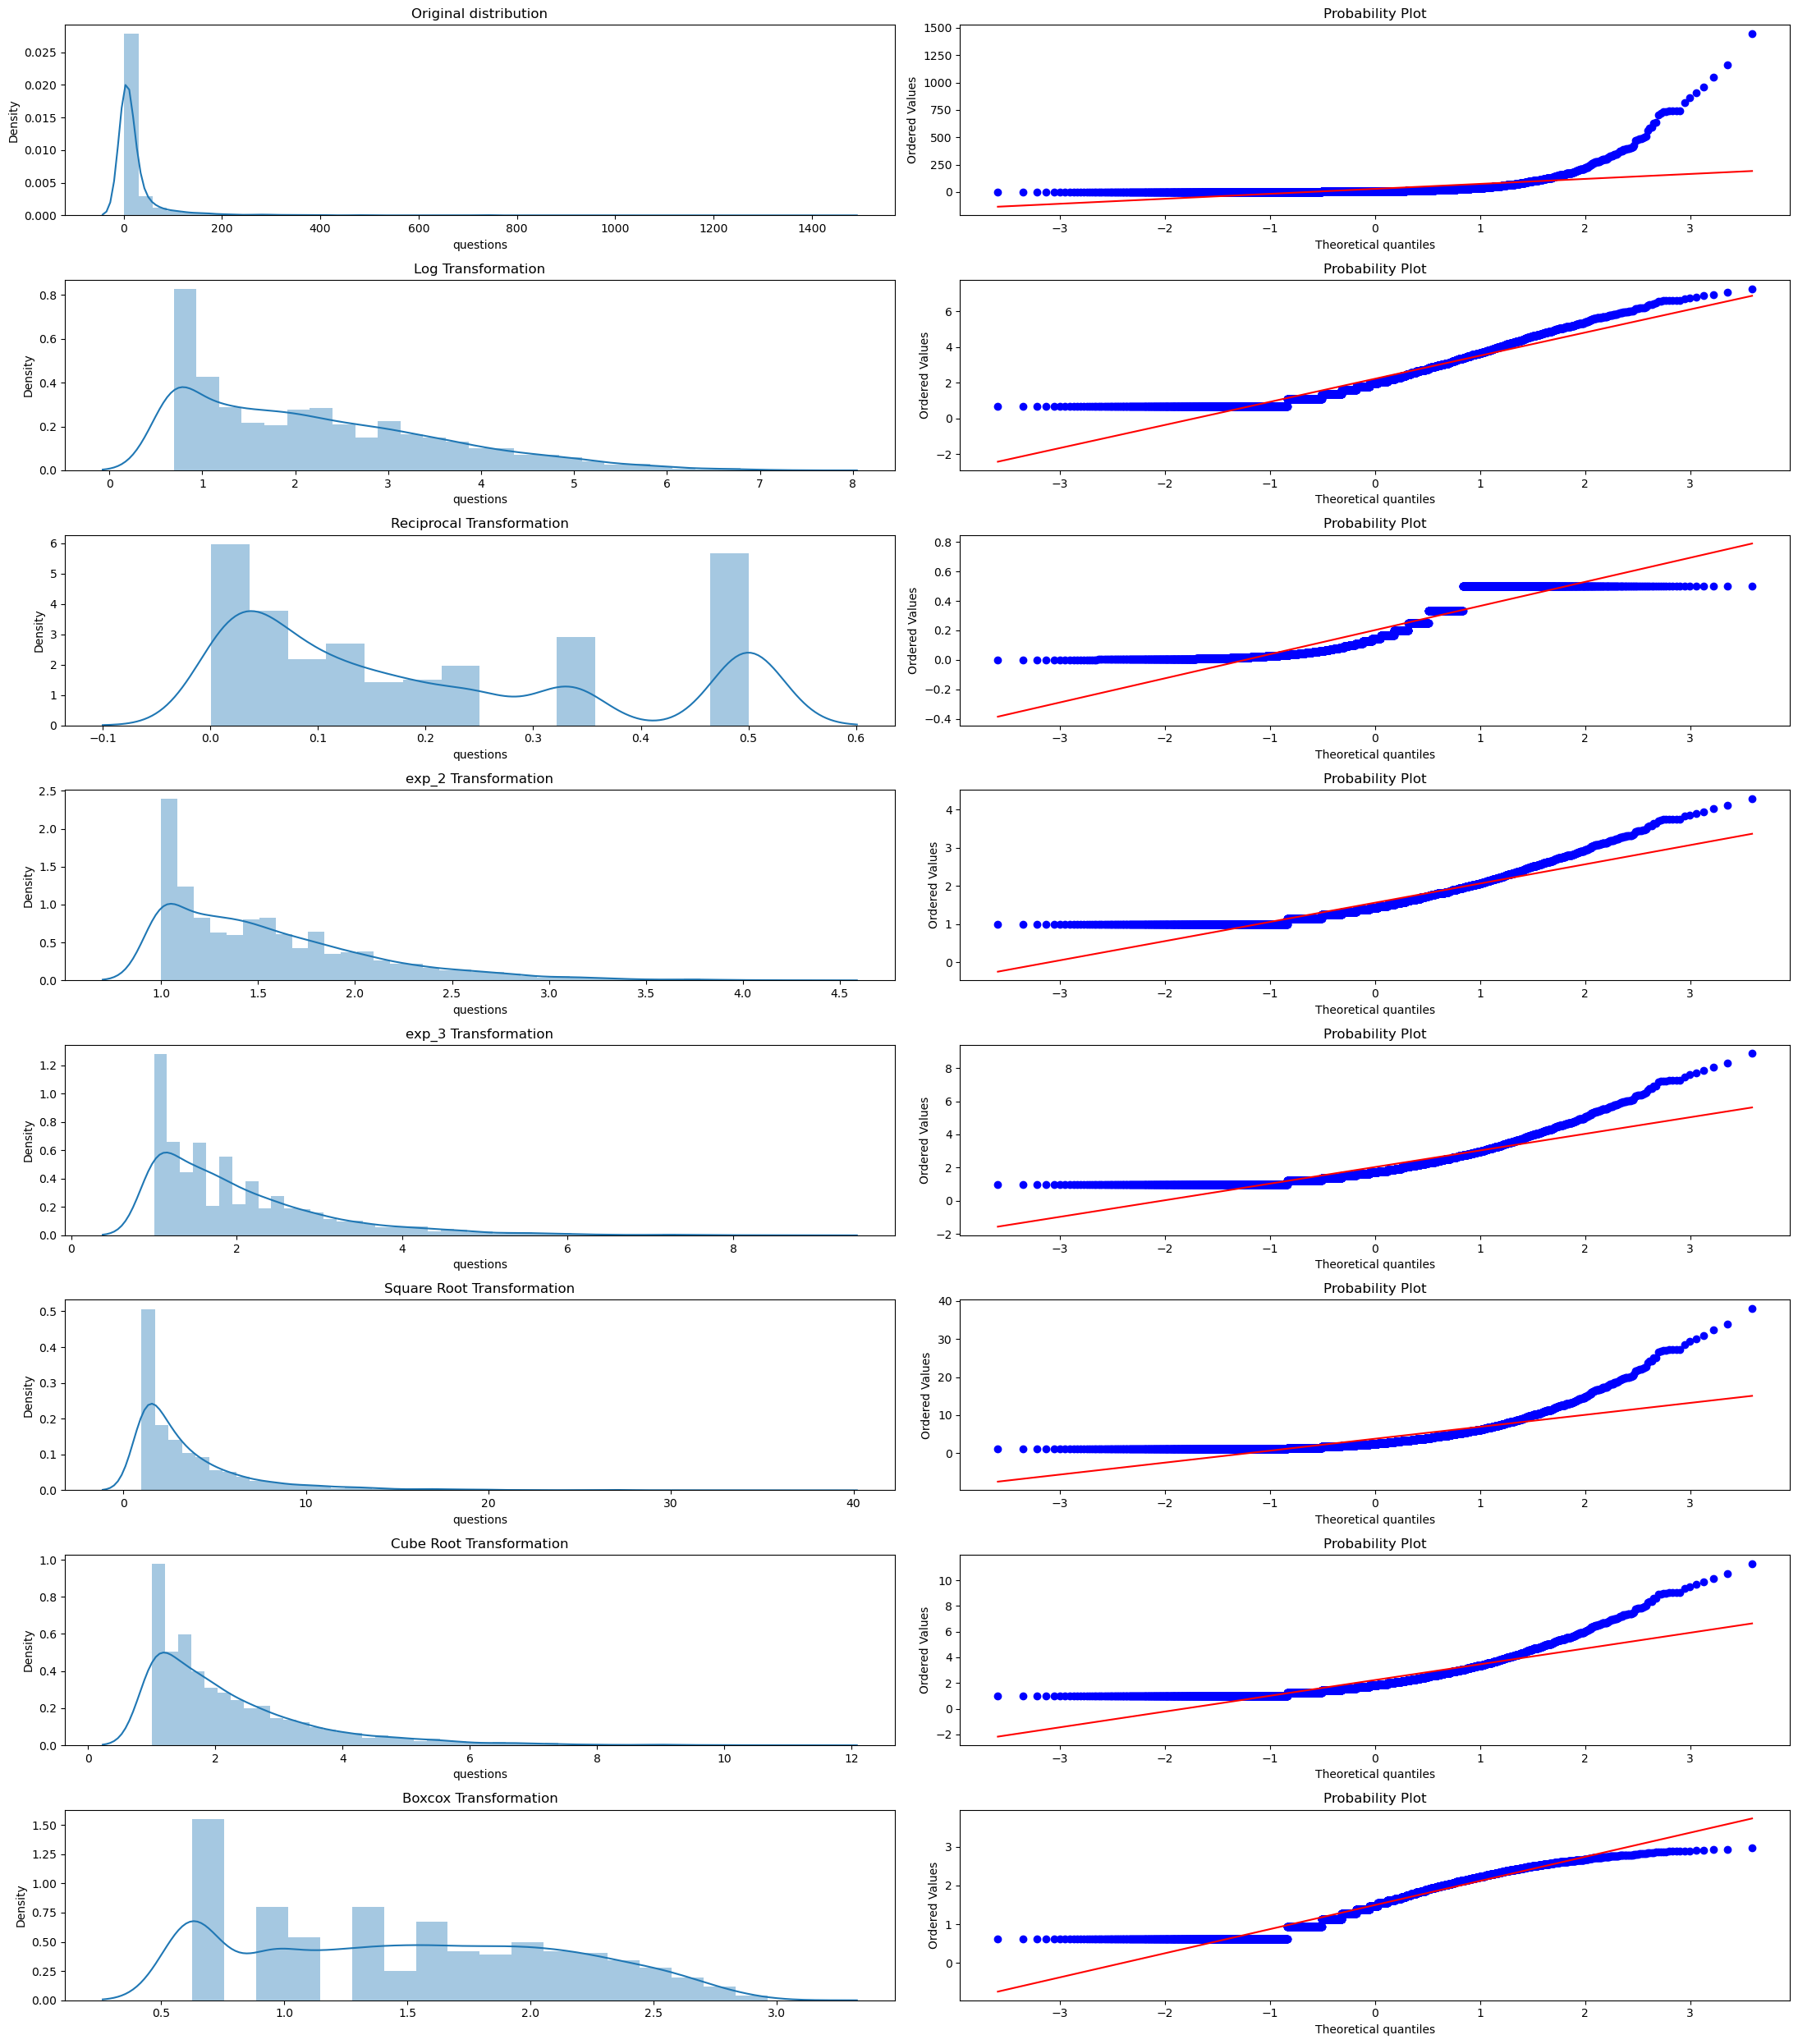

ANSWERS 

       Transformation      Skew
               Actual 28.695202
                  Log  1.099415
           Reciprocal  0.141493
Exponential power 0.2  0.401824
Exponential power 0.3  1.473270
          Square Root  5.341395
            Cube Root  1.932211
               Boxcox  0.294260

 Best Transformation for  answers : 
 Reciprocal = 0.1414931528248342


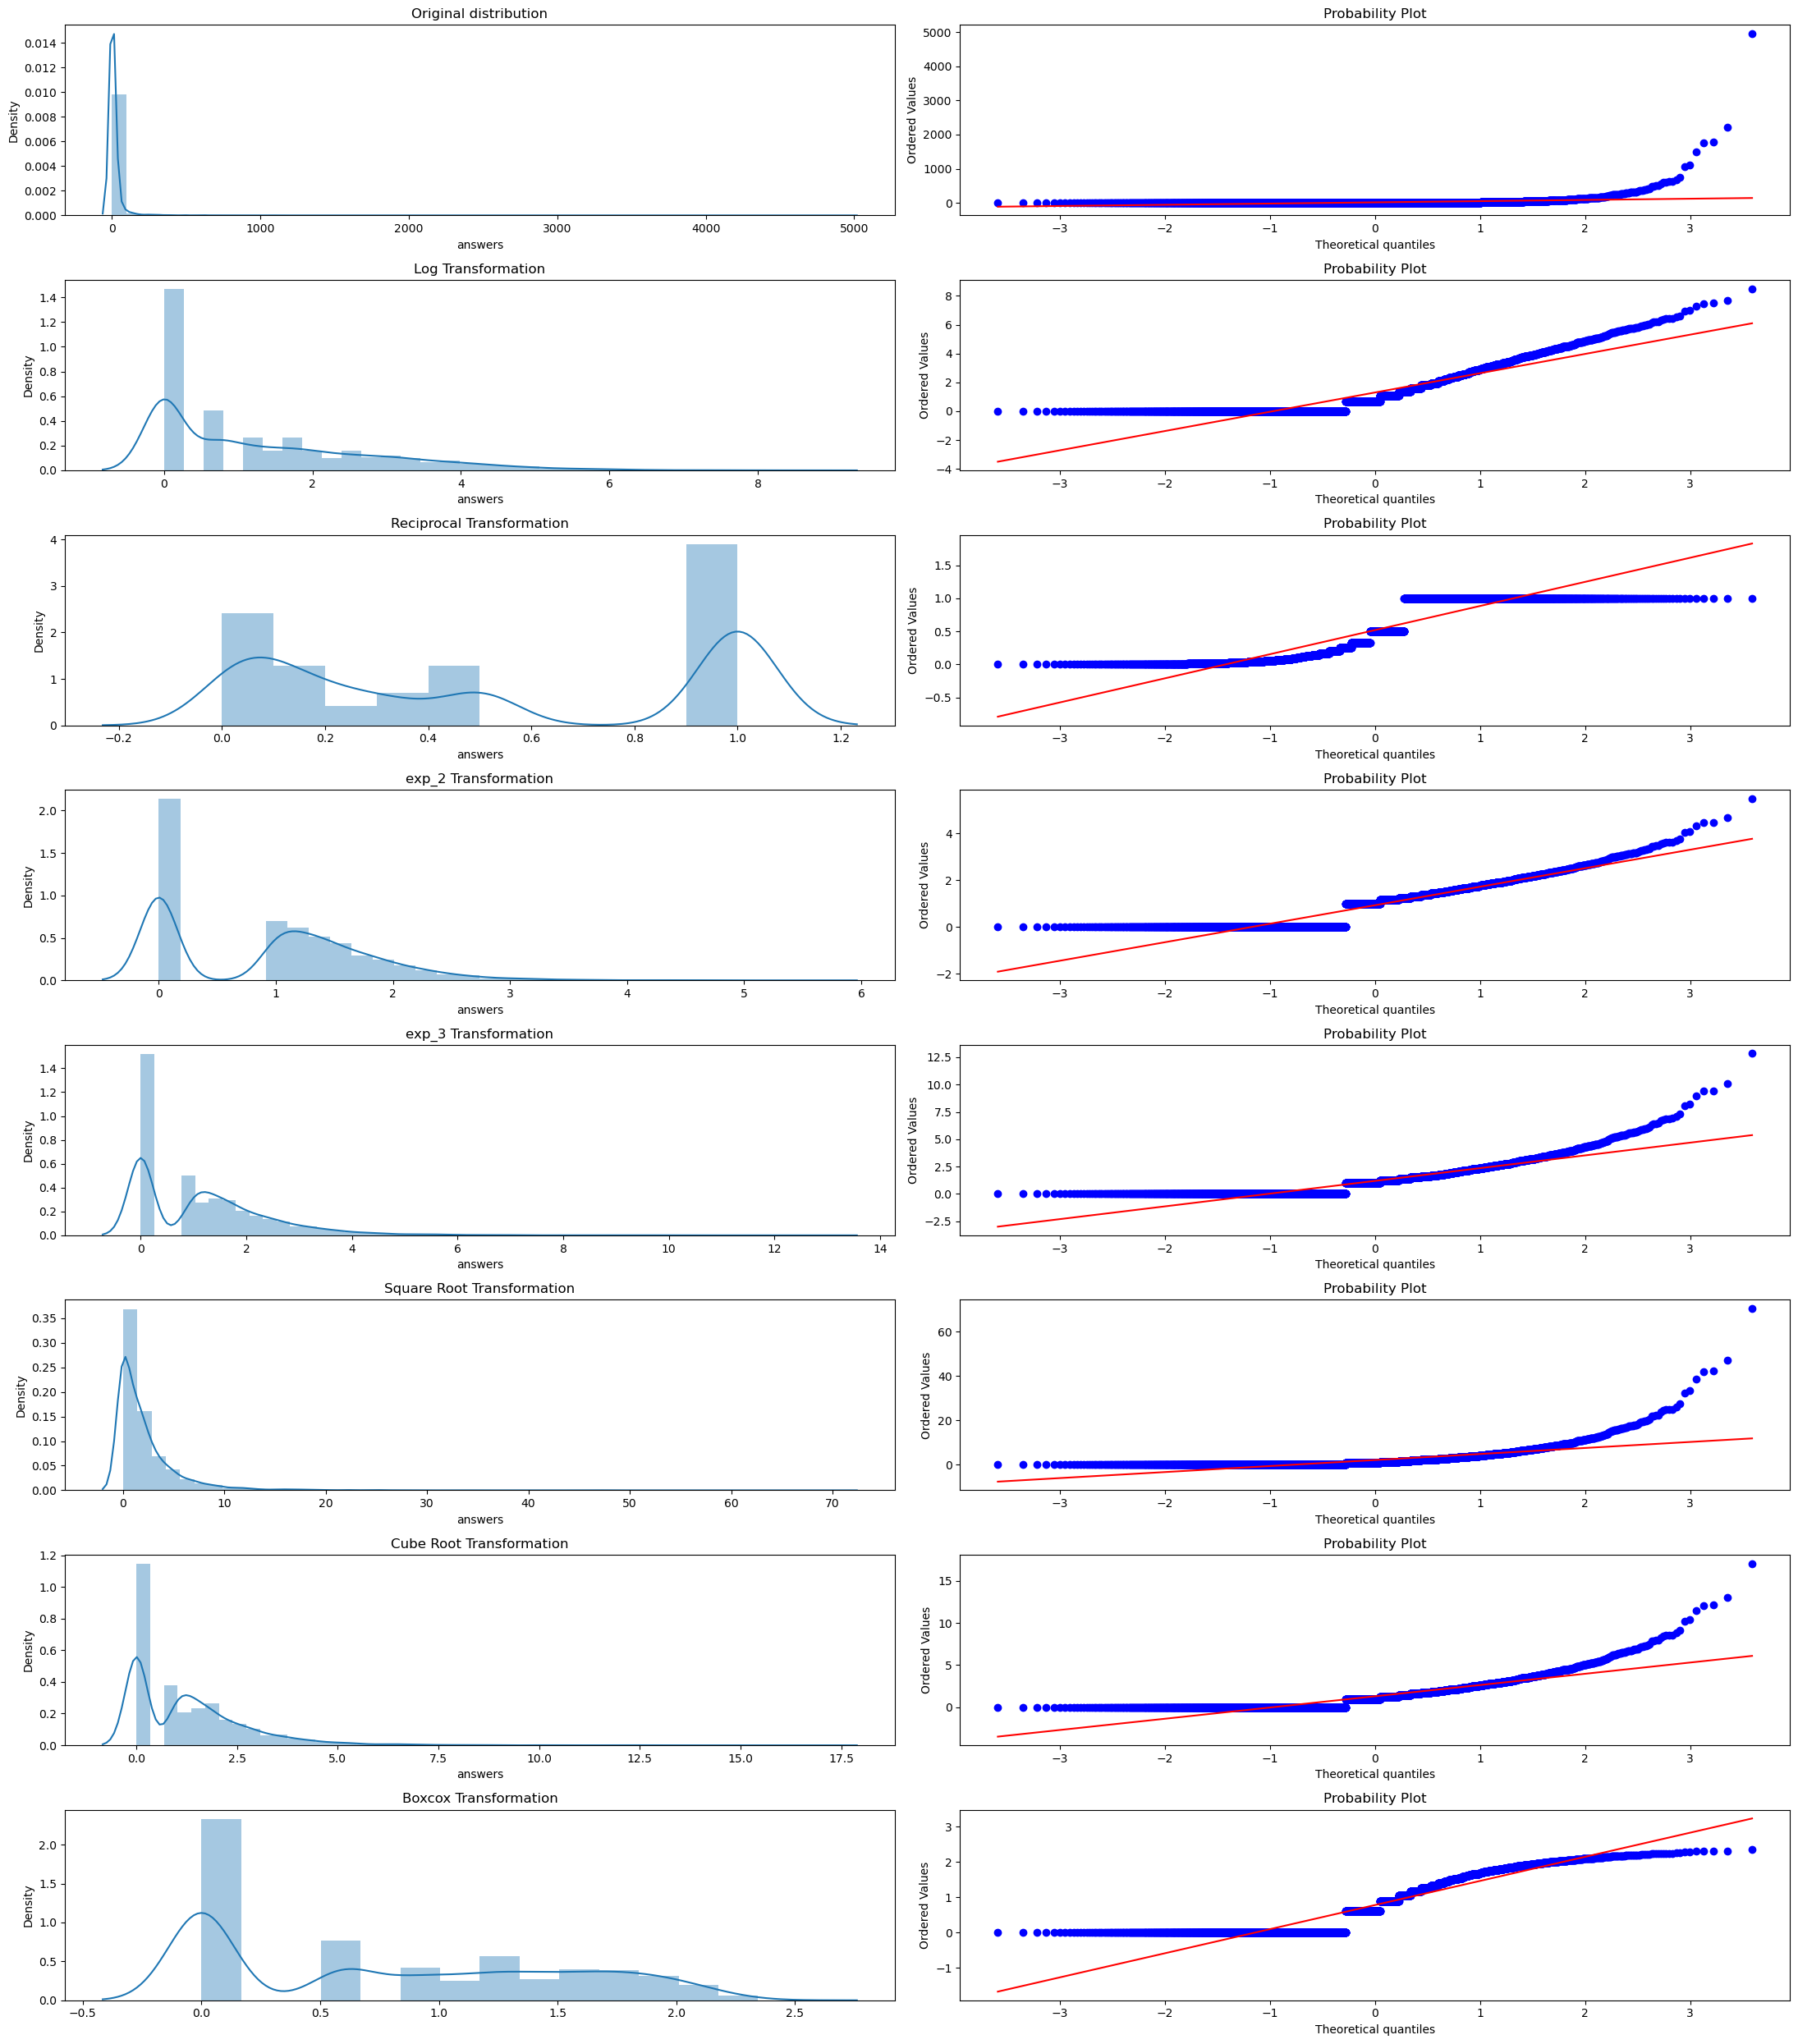

POSTS_EDITED 

       Transformation      Skew
               Actual 56.626724
                  Log  4.041352
           Reciprocal -2.234874
Exponential power 0.2  2.986711
Exponential power 0.3  5.537963
          Square Root 21.454247
            Cube Root  7.072167
               Boxcox  1.975008

 Best Transformation for  posts_edited : 
 Boxcox = 1.9750079266647618


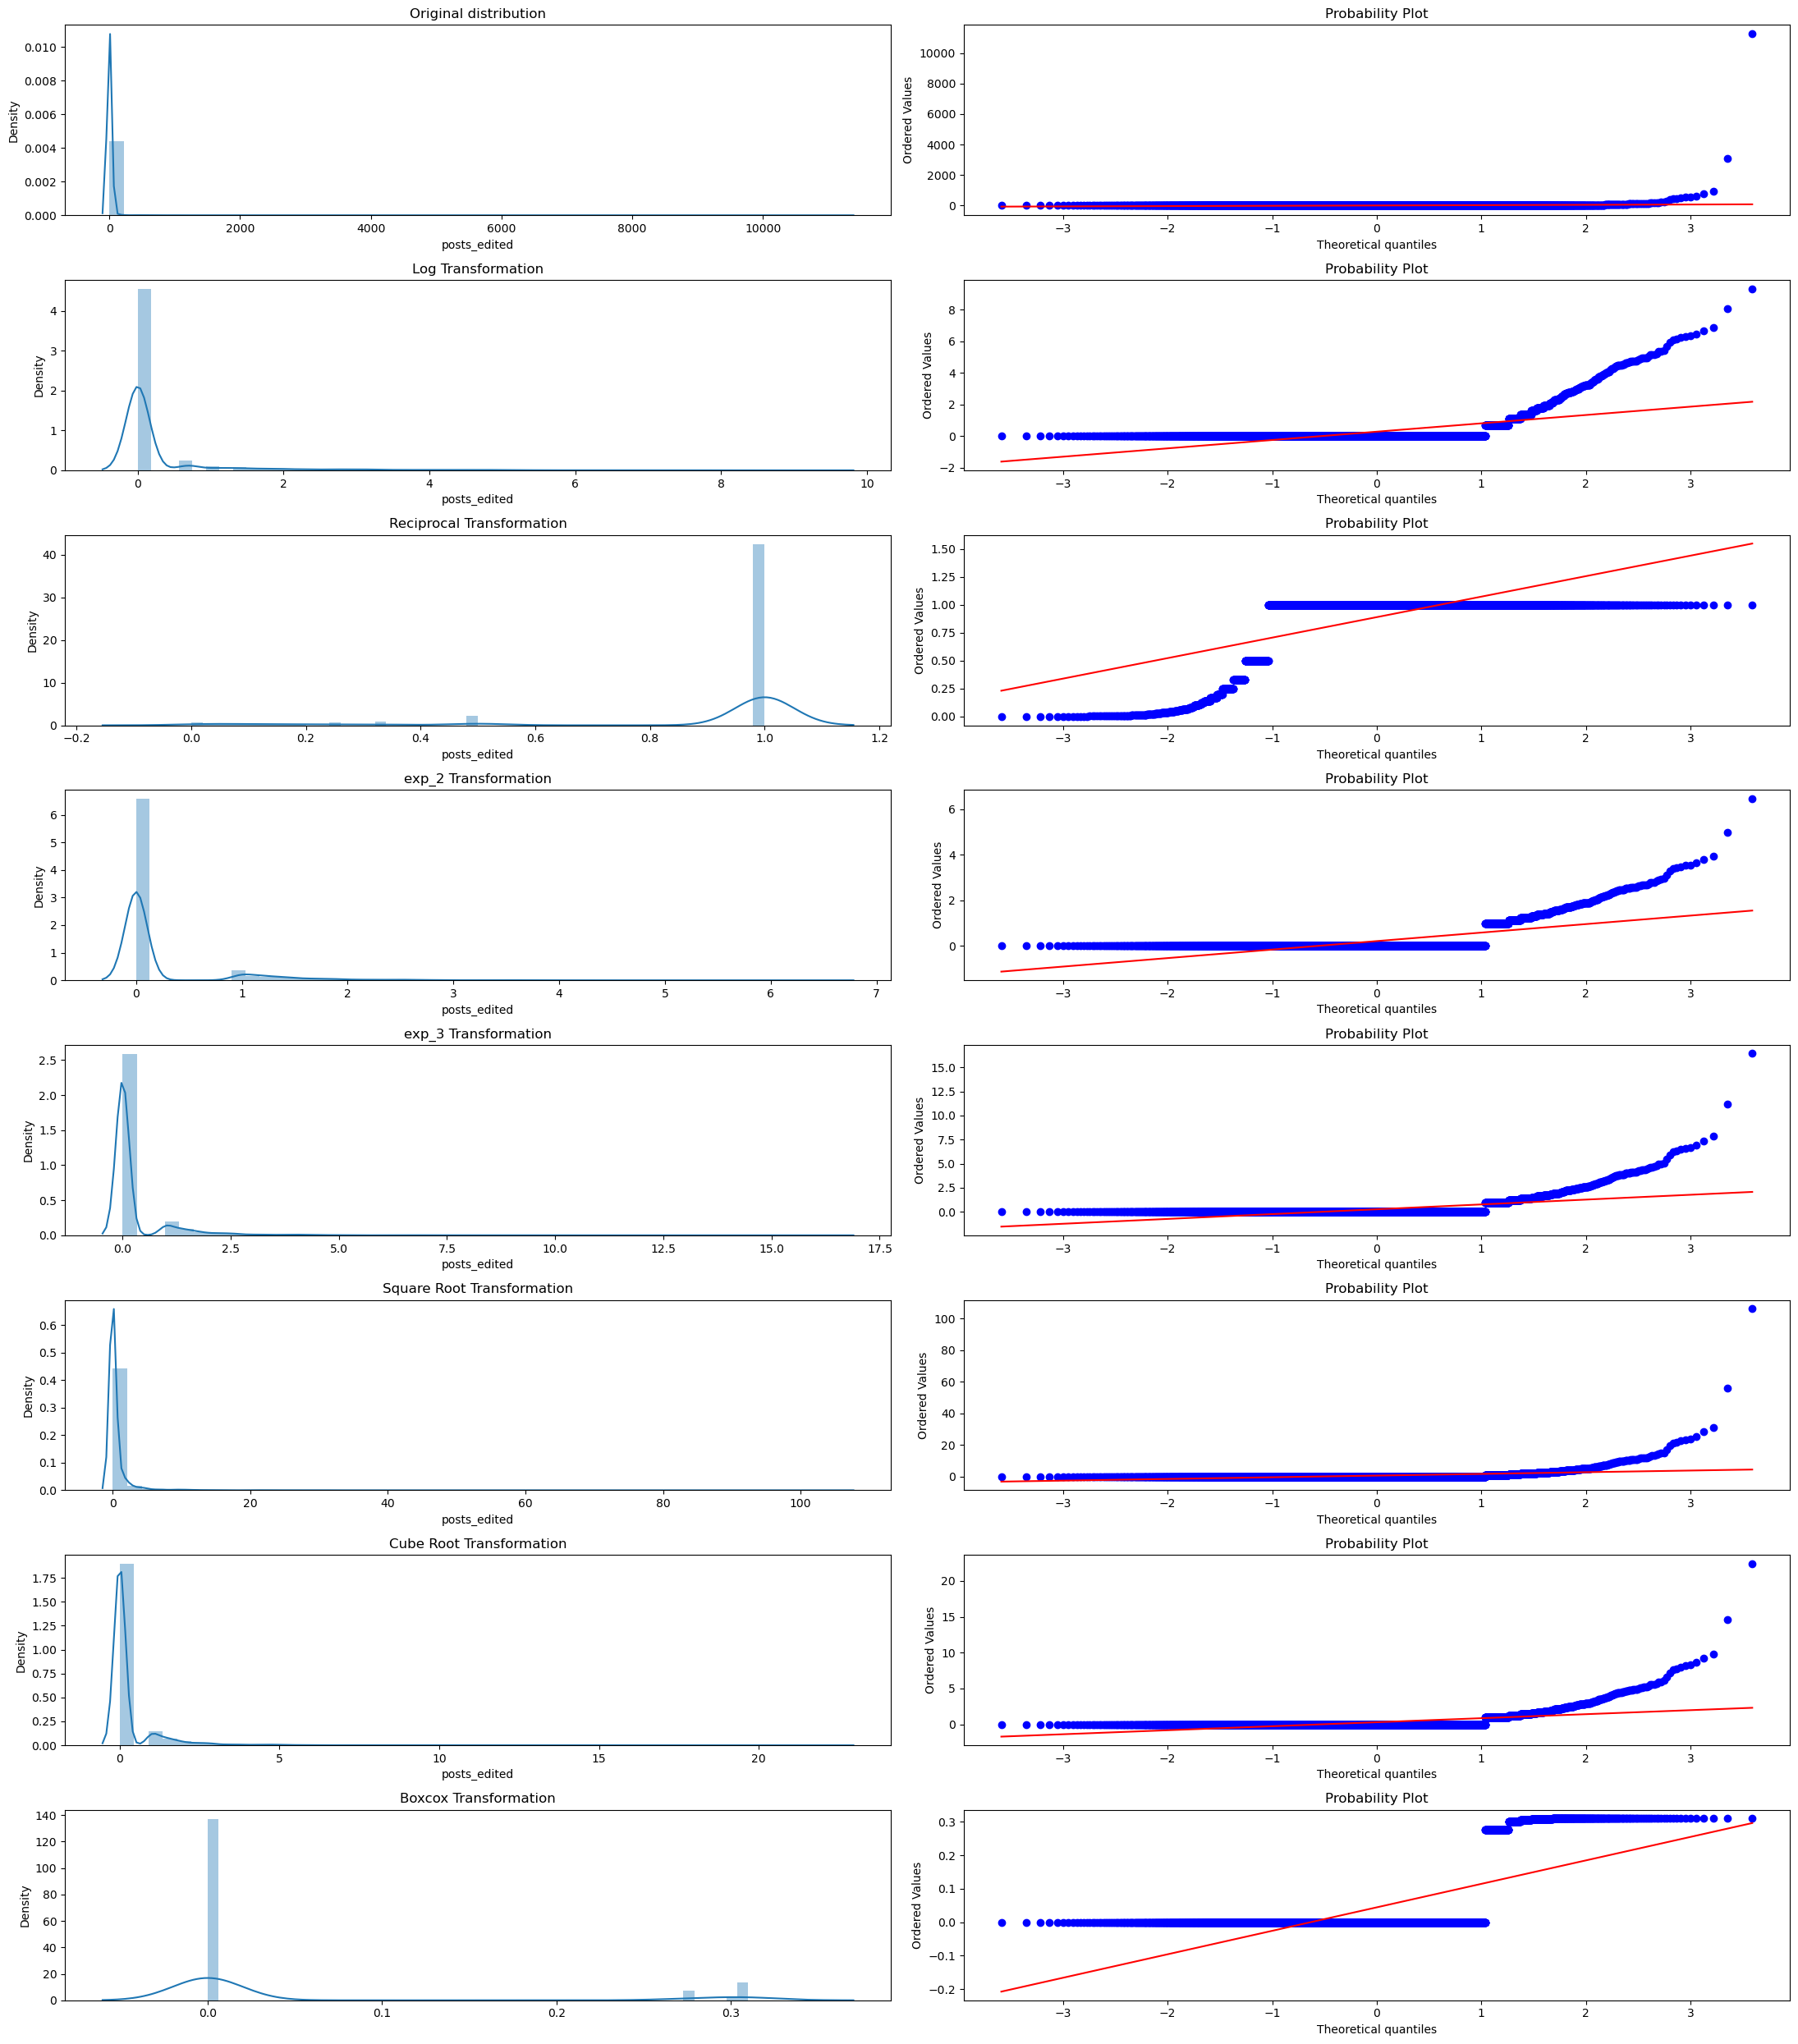

HELPFUL_TAGS 

       Transformation      Skew
               Actual 27.834087
                  Log  4.980554
           Reciprocal -2.771886
Exponential power 0.2  3.320319
Exponential power 0.3  5.182217
          Square Root 12.814551
            Cube Root  6.132032
               Boxcox  2.432791

 Best Transformation for  helpful_tags : 
 Boxcox = 2.432790806795854


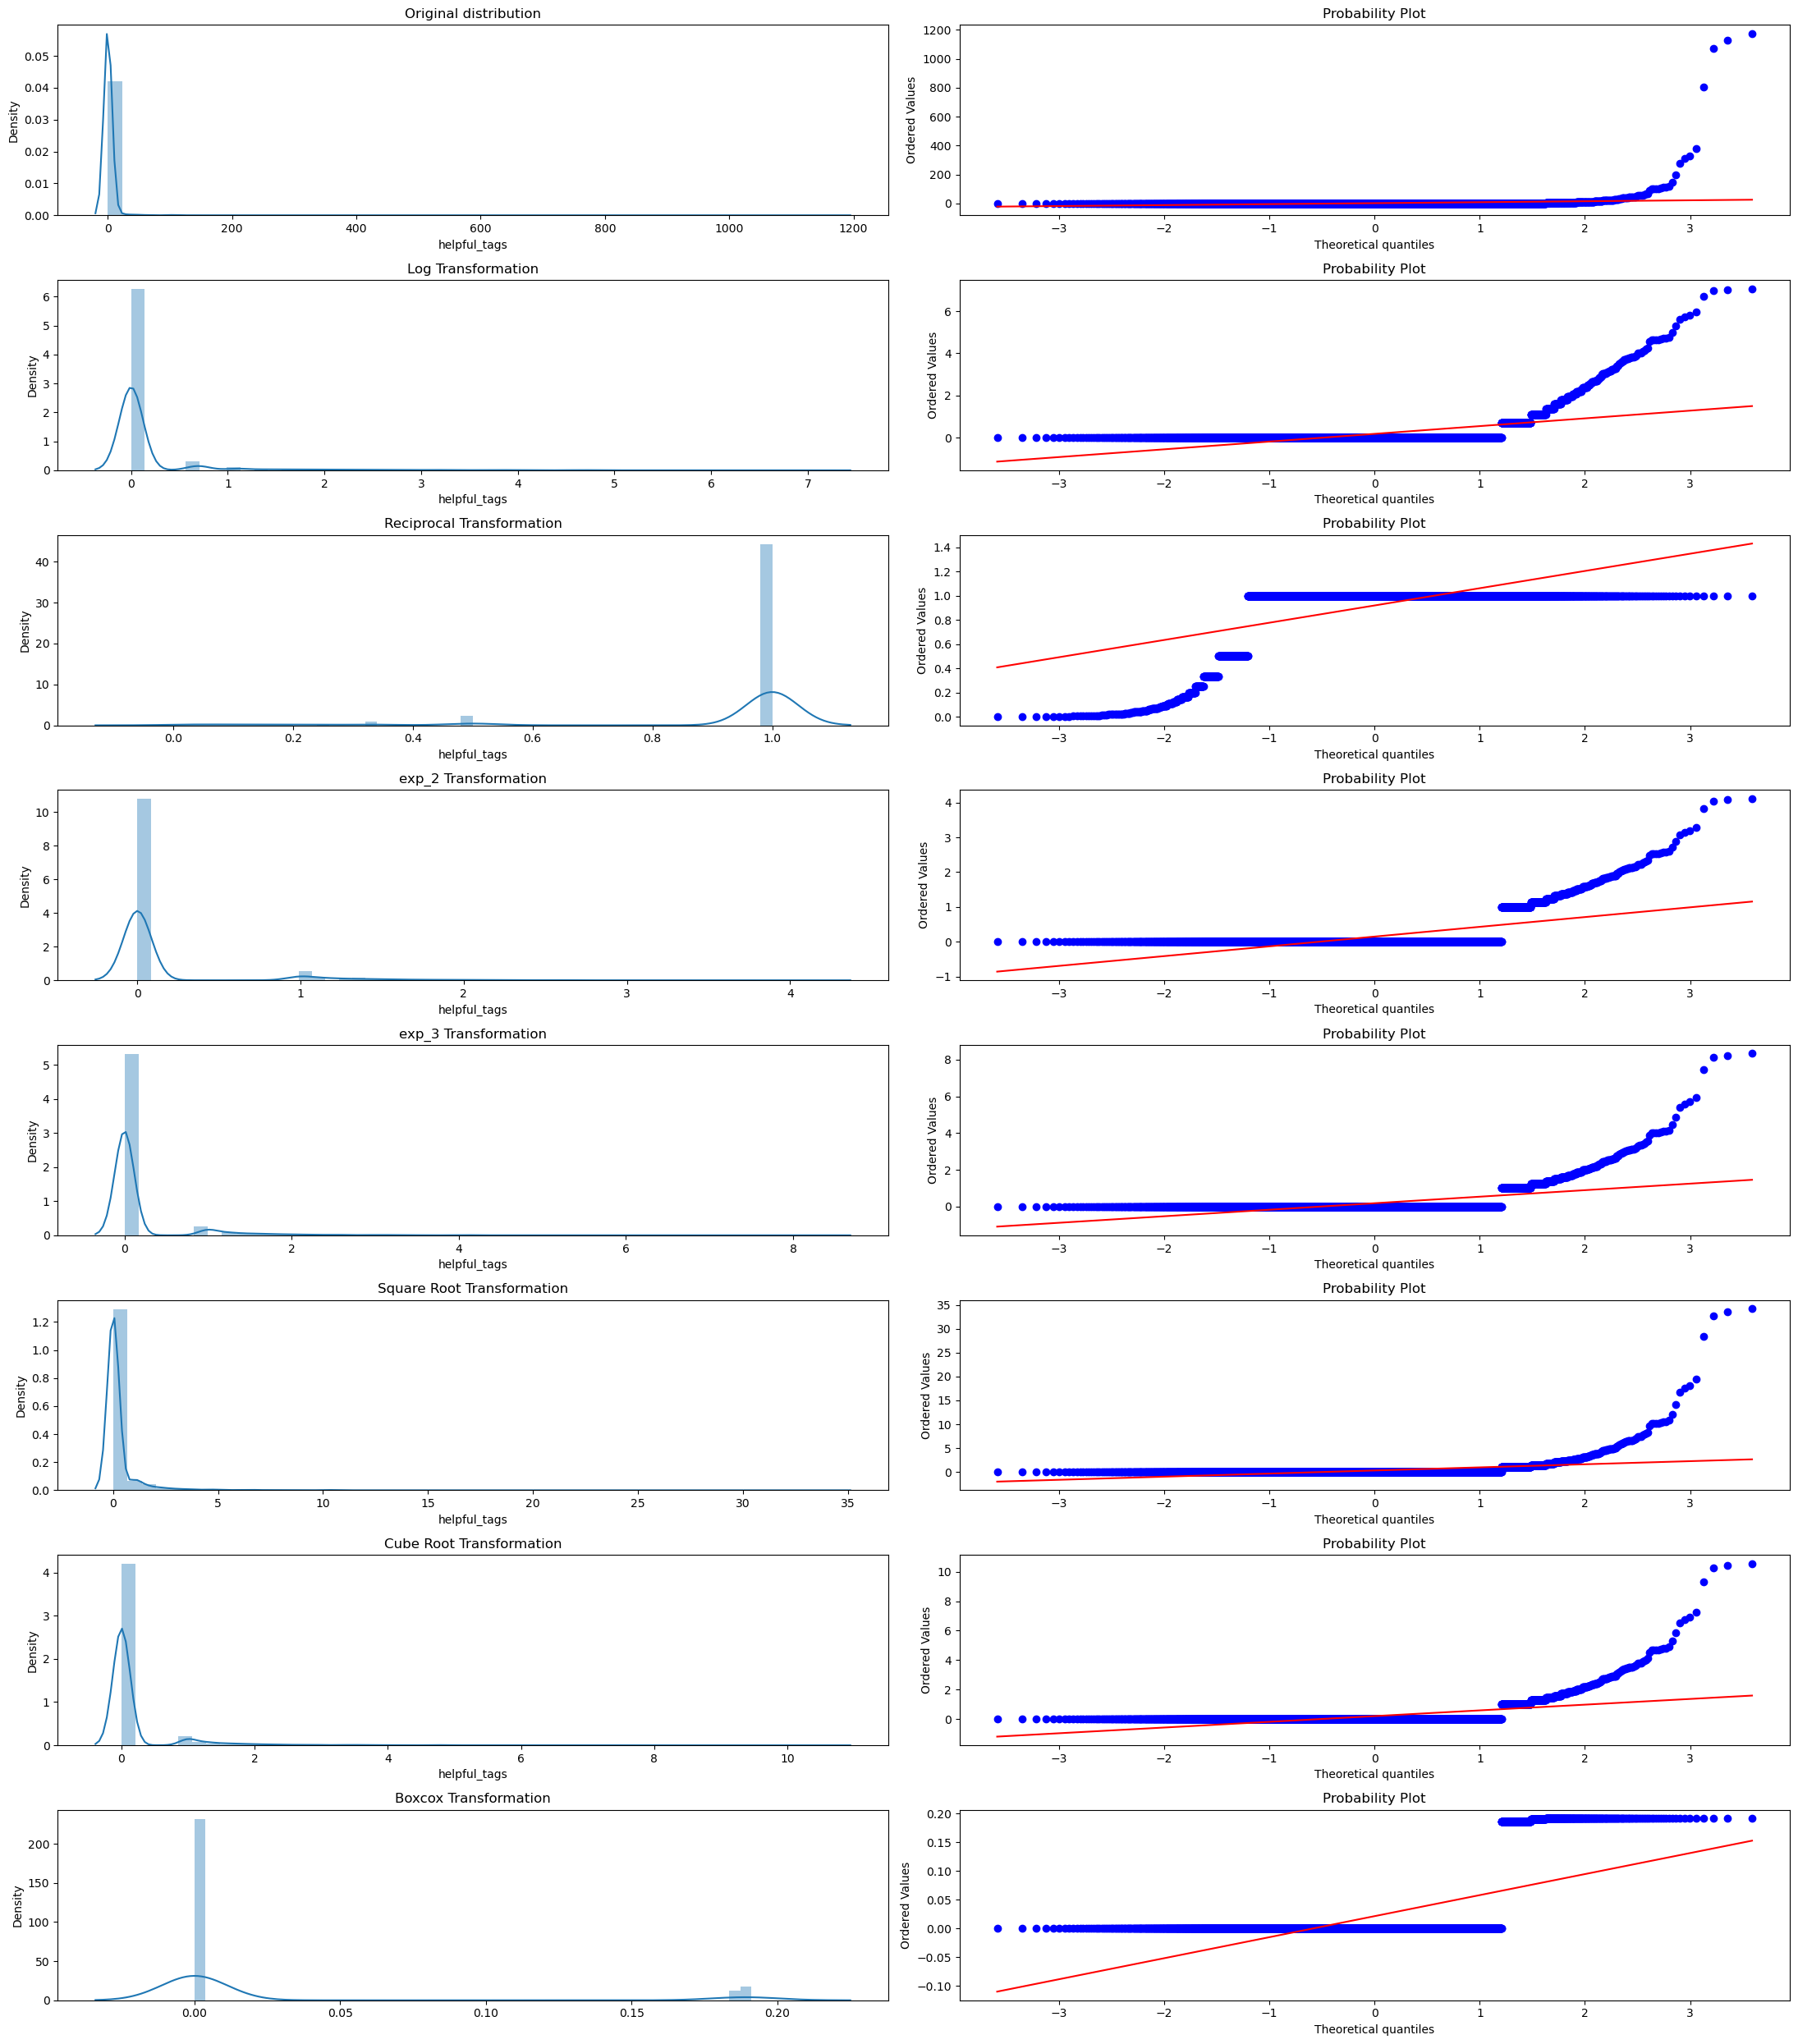

VOTES_CAST 

       Transformation      Skew
               Actual 28.919174
                  Log  0.796215
           Reciprocal  0.228352
Exponential power 0.2  0.749243
Exponential power 0.3  1.722288
          Square Root  4.491547
            Cube Root  2.079800
               Boxcox  0.285091

 Best Transformation for  votes_cast : 
 Reciprocal = 0.22835172411719726


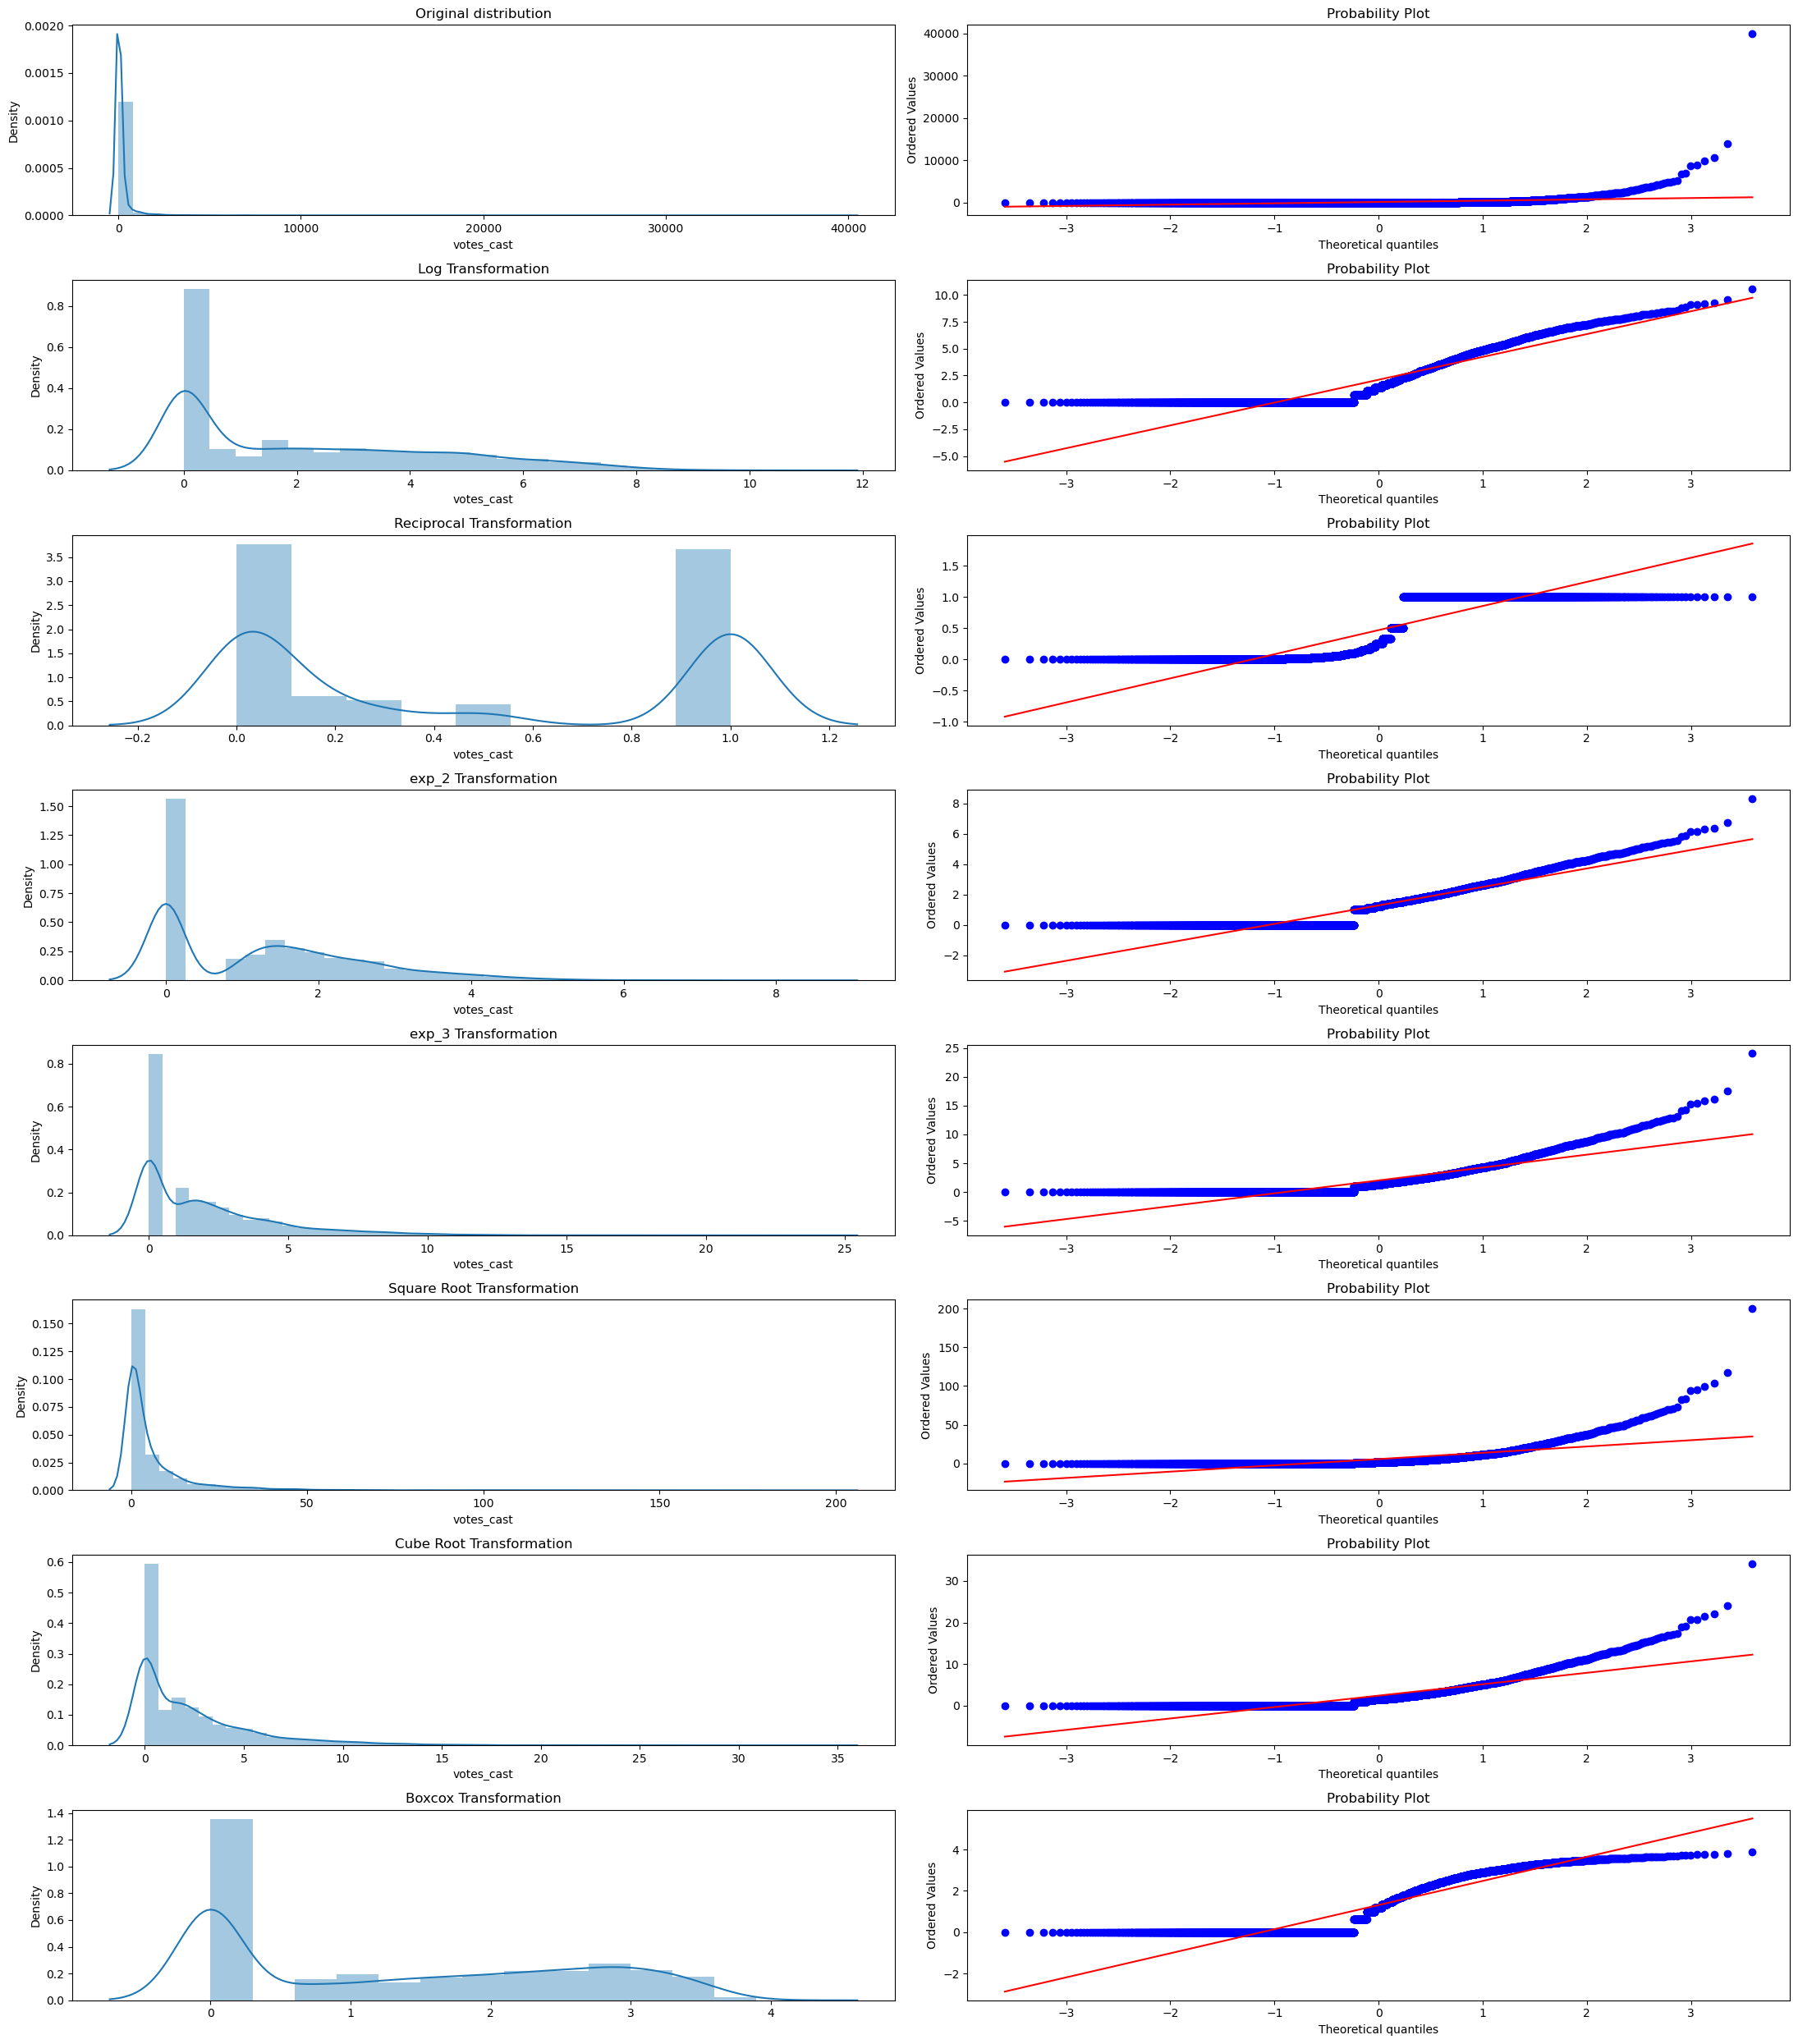

WEIGHTED_BADGE_SCORE 

       Transformation      Skew
               Actual  7.642592
                  Log -0.044626
           Reciprocal  2.887880
Exponential power 0.2 -0.473758
Exponential power 0.3  0.757111
          Square Root  2.471683
            Cube Root  1.079583
               Boxcox  0.000310

 Best Transformation for  weighted_badge_score : 
 Boxcox = 0.00031009632548419135


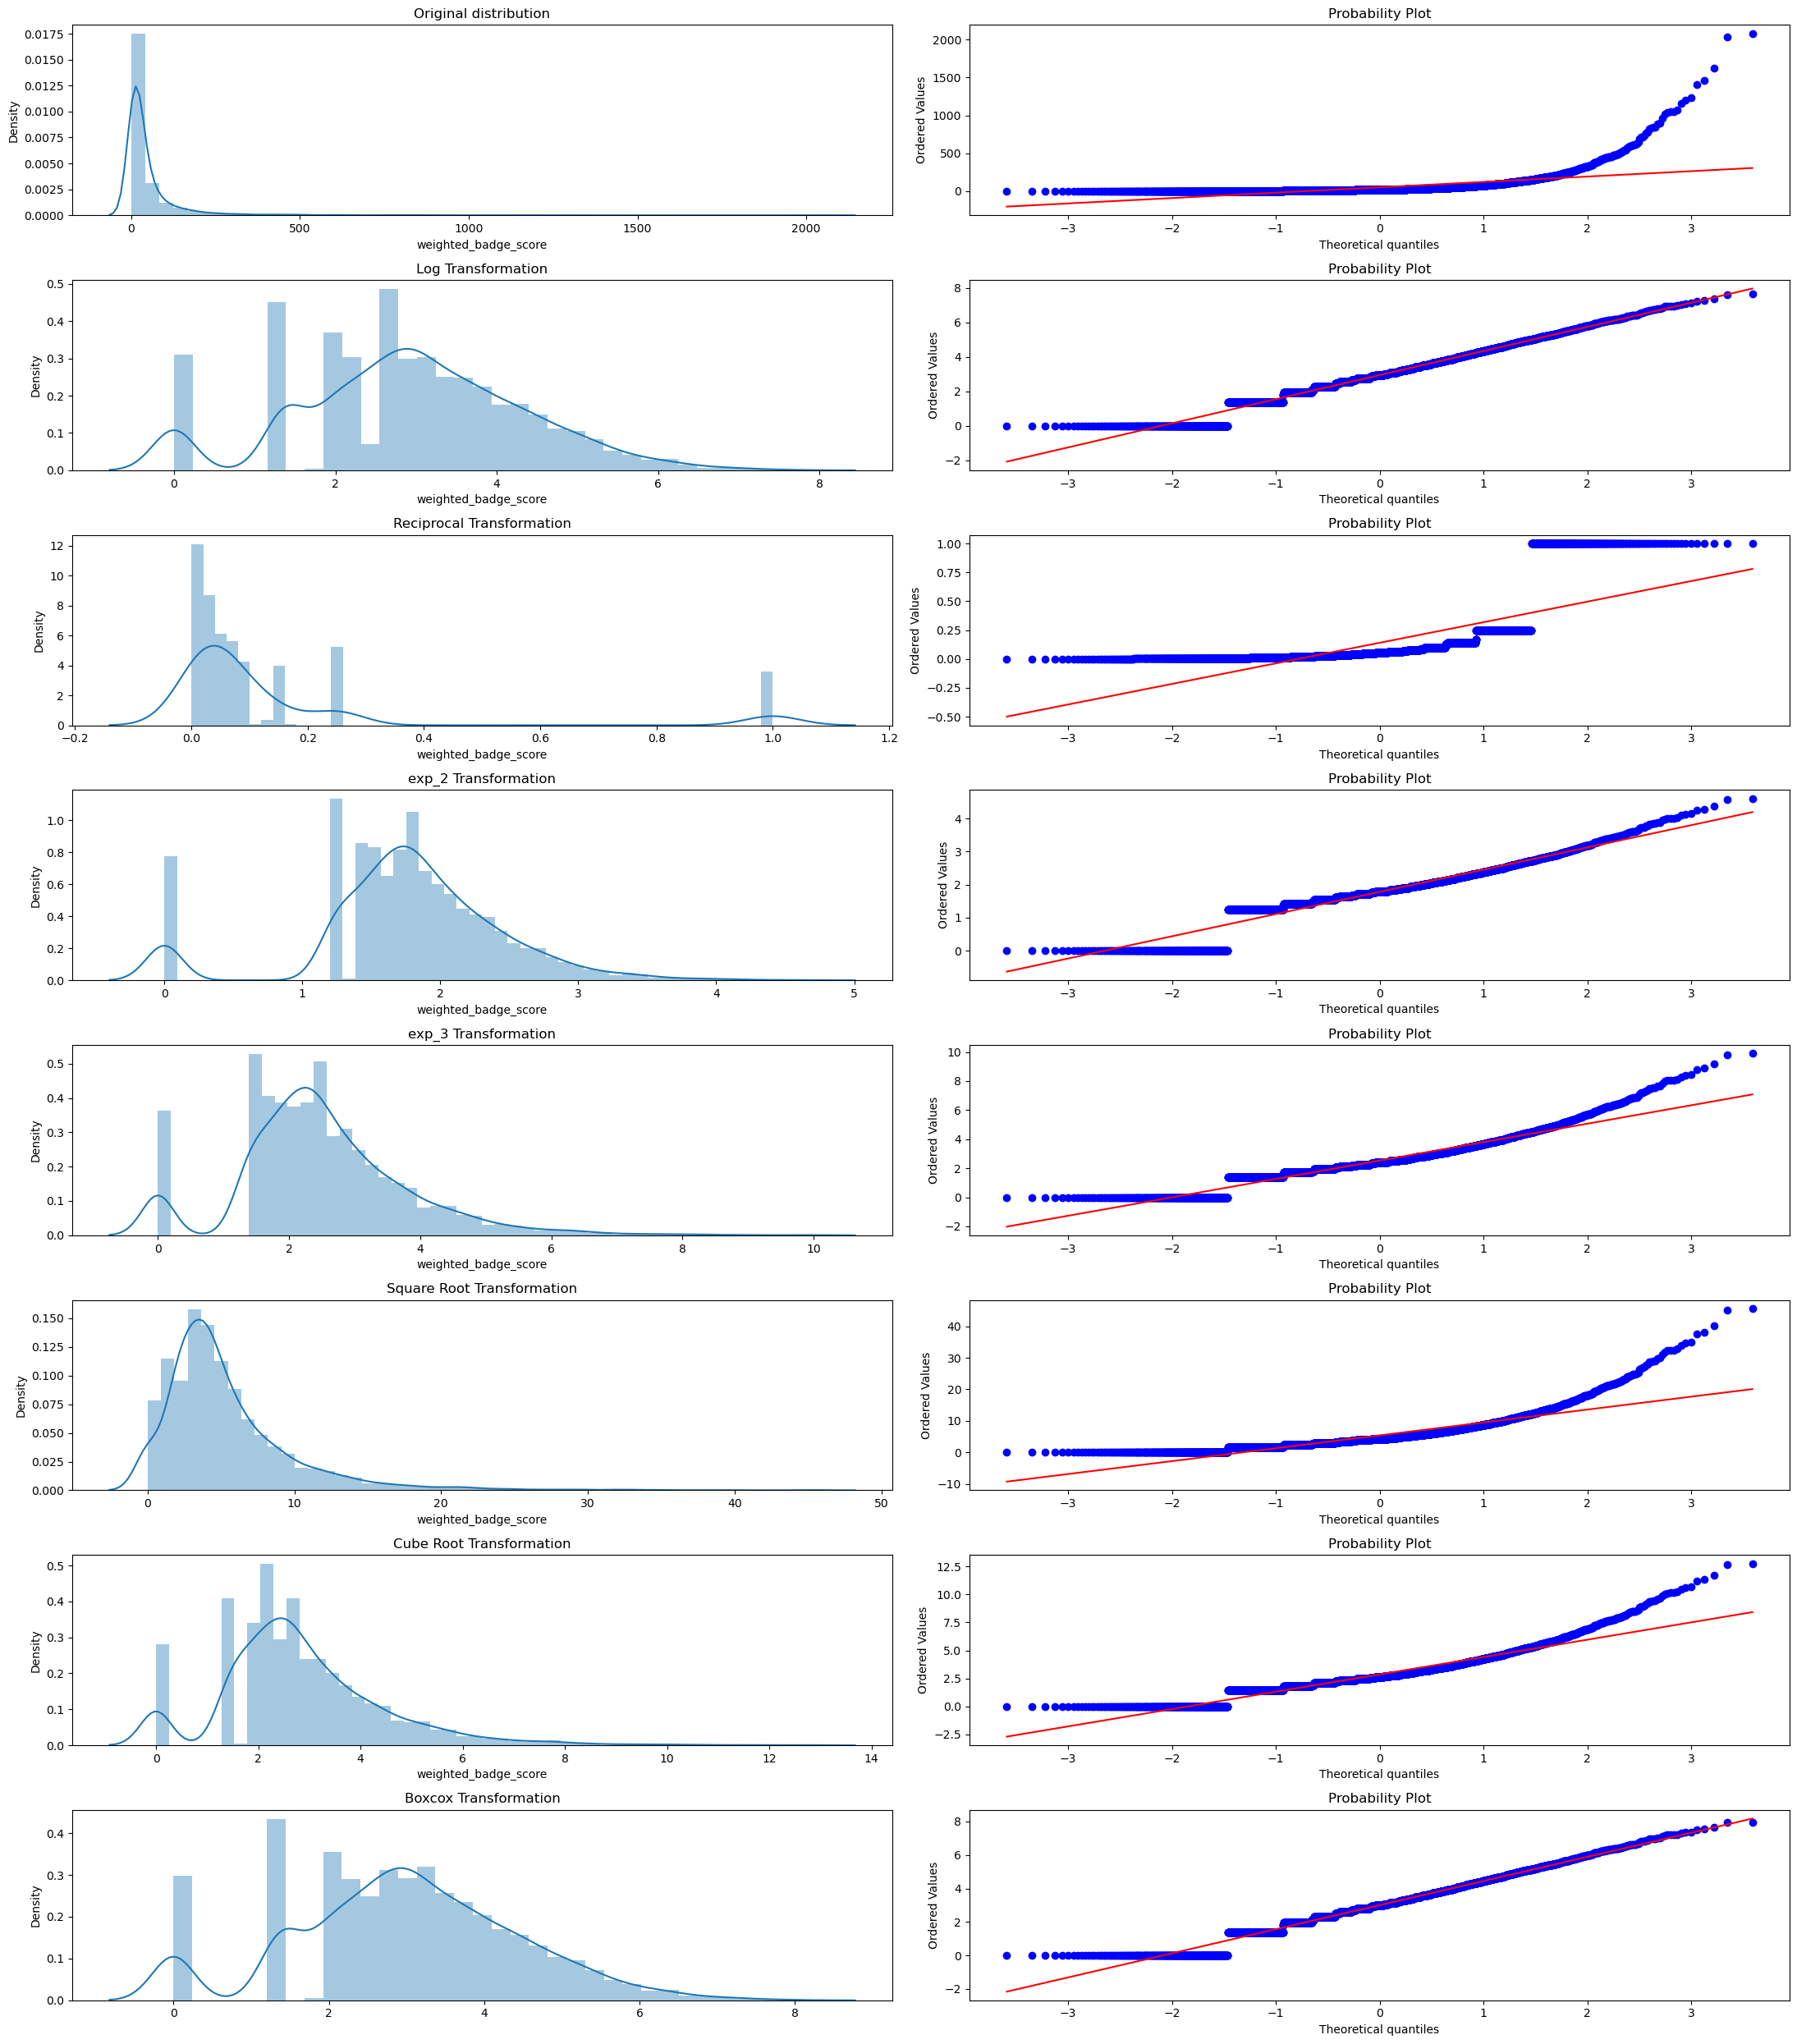

QA_RATIO 

       Transformation      Skew
               Actual 25.793214
                  Log  3.197227
           Reciprocal -1.113932
Exponential power 0.2  0.199139
Exponential power 0.3  1.251660
          Square Root  6.324577
            Cube Root  1.779772
               Boxcox  0.562883

 Best Transformation for  QA_ratio : 
 Exponential power 0.2 = 0.19913880117790567


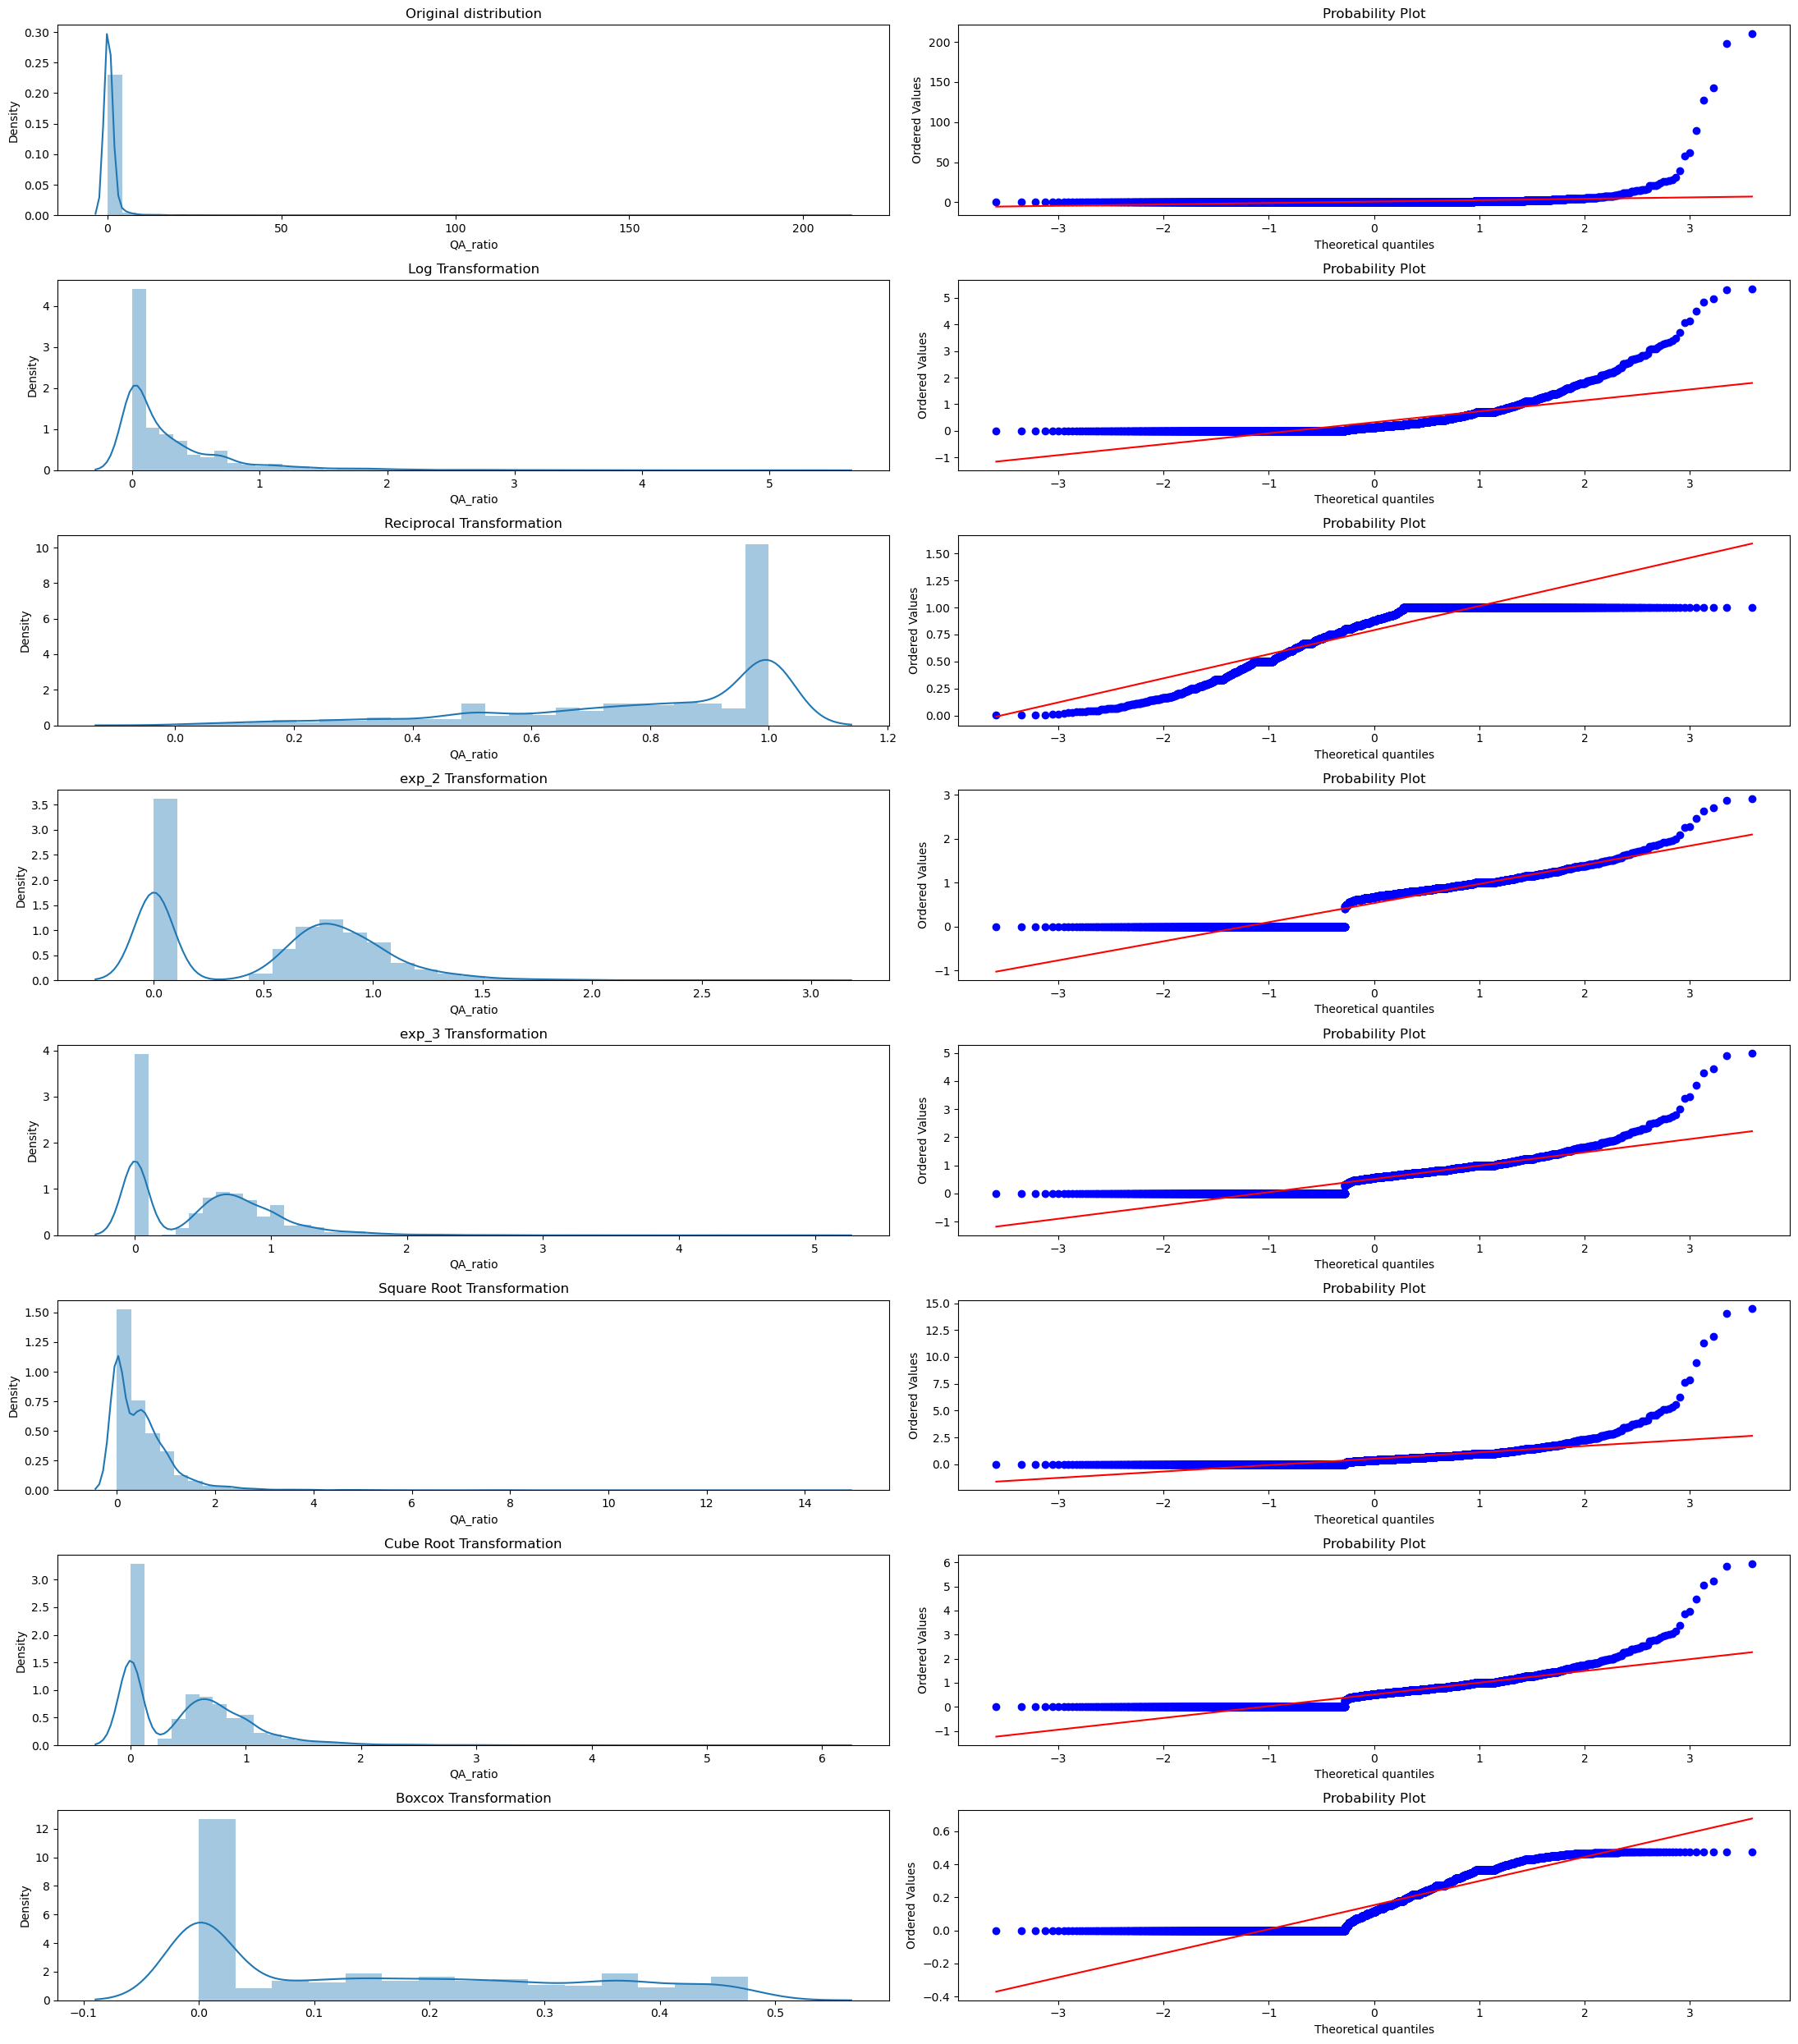

In [14]:
for column in ['reputation', 'reached', 'questions', 'answers',
        'posts_edited', 'helpful_tags', 'votes_cast',
        'weighted_badge_score', 'QA_ratio']:
    
    print('\033[1m'+column.upper()+'\033[0m','\n')
    plt.figure(figsize=(22,25))
    
    raw_skewness = df_train[column].skew()
    
    plt.subplot(8,2,1)
    sns.distplot(df_train[column])
    plt.title('Original distribution')
    
    plt.subplot(8,2,2)
    st.probplot(df_train[column],dist='norm',plot=plt)
    
    
    #log transformation
    log_transform = np.log(df_train[column]+1)
    log_skew=log_transform.skew()

    plt.subplot(8,2,3)
    sns.distplot(log_transform)
    plt.title('Log Transformation')

    plt.subplot(8,2,4)
    st.probplot(log_transform,dist='norm',plot=plt)
    
    #Reciprocal Transformation  
    recip_transform = 1/(df_train[column]+1)
    recip_skew=recip_transform.skew()

    plt.subplot(8,2,5)
    sns.distplot(recip_transform)
    plt.title('Reciprocal Transformation')

    plt.subplot(8,2,6)
    st.probplot(recip_transform,dist='norm',plot=plt)
    
    #Exponential Transformation
    
    exp_2 = df_train[column]**0.2
    exp_2_skew=exp_2.skew()
    
    plt.subplot(8,2,7)
    sns.distplot(exp_2)
    plt.title('exp_2 Transformation')
    
    plt.subplot(8,2,8)
    st.probplot(exp_2,dist='norm',plot=plt)
    
    exp_3 = df_train[column]**0.3
    exp_3_skew=exp_3.skew()
    
    plt.subplot(8,2,9)
    sns.distplot(exp_3)
    plt.title('exp_3 Transformation')
    
    plt.subplot(8,2,10)
    st.probplot(exp_3,dist='norm',plot=plt)
    
    #Square Root Transformation
    
    sqrt_transform = df_train[column]**(1/2)
    sqrt_transform_skew=sqrt_transform.skew()
    
    plt.subplot(8,2,11)
    sns.distplot(sqrt_transform)
    plt.title('Square Root Transformation')
    
    plt.subplot(8,2,12)
    st.probplot(sqrt_transform,dist='norm',plot=plt)
    
    #Cube Root Transformation
    
    cube_transform = df_train[column]**(1/3)
    cube_transform_skew=cube_transform.skew()
    
    plt.subplot(8,2,13)
    sns.distplot(cube_transform)
    plt.title('Cube Root Transformation')
    
    plt.subplot(8,2,14)
    st.probplot(cube_transform,dist='norm',plot=plt)
    
    #Boxcox Transformation
    box,param = st.boxcox(df_train[column]+1)
    boxcox_skew=pd.DataFrame(box).skew()

    plt.subplot(8,2,15)
    plt.tight_layout()
    sns.distplot(pd.DataFrame(box))
    plt.title('Boxcox Transformation')

    plt.subplot(8,2,16)
    st.probplot(box,dist='norm',plot=plt)
    
    trans_result= {'Actual':raw_skewness, 'Log':log_skew,'Reciprocal':recip_skew,'Exponential power 0.2':exp_2_skew,
                       'Exponential power 0.3':exp_3_skew,'Square Root':sqrt_transform_skew,
                       'Cube Root':cube_transform_skew,'Boxcox':boxcox_skew[0]}
    print(pd.DataFrame(trans_result.items(), columns=['Transformation', 'Skew']).to_string(index=False))
    
    lst=list(trans_result.values())
    idx = min((abs(x), x) for x in lst)[1]
    for i in trans_result:
        if (trans_result[i]==idx):
            print('\n','Best Transformation for ',column,':','\n',i,'=',trans_result[i])
    plt.tight_layout() 
    
    plt.show()

In [14]:
df_train['reputation_st'],rep = st.boxcox(df_train['reputation']+1)
df_train['reached_st'],reach = st.boxcox(df_train['reached']+1)
df_train['questions_st'],ques = st.boxcox(df_train['questions']+1)
# df_train['answers_st'] = df_train['answers']**0.2
# df_train['answers_st'],ans = st.boxcox(df_train['answers']+1)
df_train['answers_st'] = 1/(df_train['answers']+1)
df_train['posts_edited_st'],post = st.boxcox(df_train['posts_edited']+1)
df_train['helpful_tags_st'],helpf = st.boxcox(df_train['helpful_tags']+1)
# df_train['votes_cast_st'],vote = st.boxcox(df_train['votes_cast']+1)
df_train['votes_cast_st'] = 1/(df_train['votes_cast']+1)
df_train['weighted_badge_score_st'],badge = st.boxcox(df_train['weighted_badge_score']+1)
df_train['QA_ratio_st'] = df_train['QA_ratio']**0.2

## Scaling with Robust Scaler

In [15]:
st_columns = [i for i in df_train.columns if i.endswith('_st')]
scaler = RobustScaler()
df_train[st_columns] = scaler.fit_transform(df_train[st_columns])
scaled2 = scaler.fit_transform(df_train[['member_since_in_months','total_requirements_satisfied']])
df_scaled2 = pd.DataFrame(scaled2, columns=['member_since_in_months_st','total_requirements_satisfied_st'], index=df_train.index)
df_train = pd.concat([df_train, df_scaled2], axis=1)

In [16]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [17]:
st_columns1 = [i for i in df_train.columns if i.endswith('_st')]
calc_vif(df_train[st_columns1])

variables        VIF
0                     reputation_st  12.676722
1                        reached_st  10.130526
2                      questions_st   7.587964
3                        answers_st  13.887683
4                   posts_edited_st   1.886839
5                   helpful_tags_st   1.674583
6                     votes_cast_st   3.534783
7           weighted_badge_score_st   9.368859
8                       QA_ratio_st  10.054429
9         member_since_in_months_st   2.273902
10  total_requirements_satisfied_st   1.081297

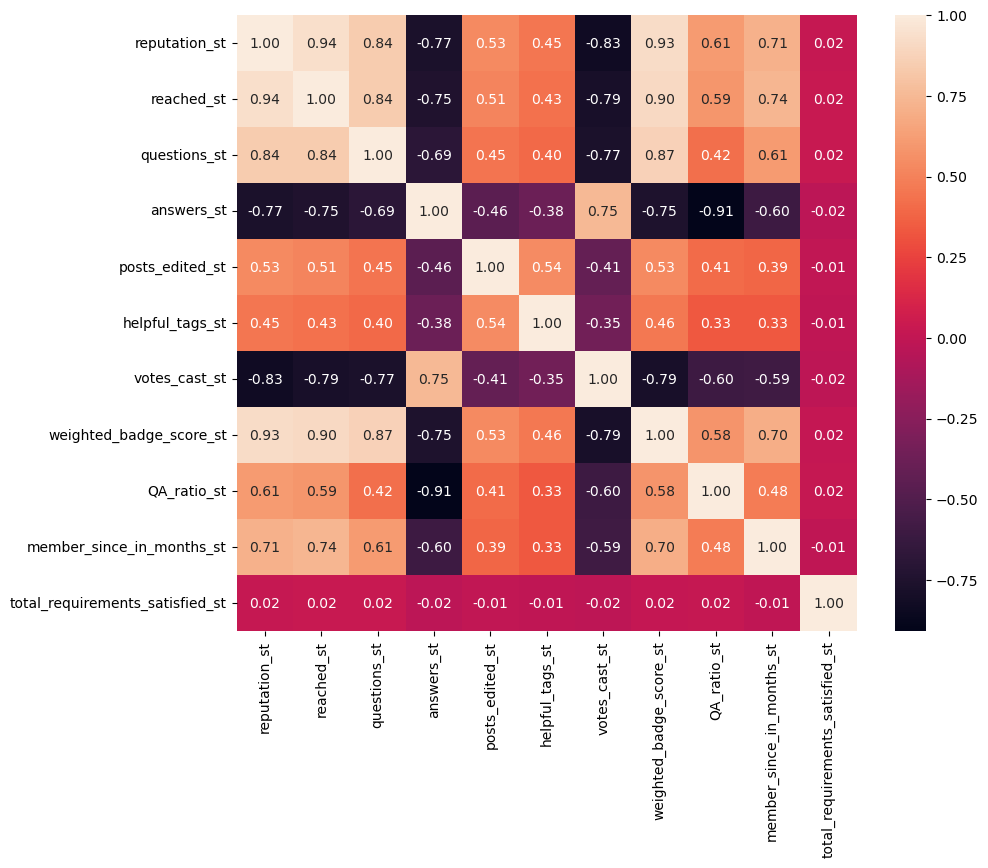

In [18]:
corr_matrix = df_train[st_columns1].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f")
plt.show()

## Modelling

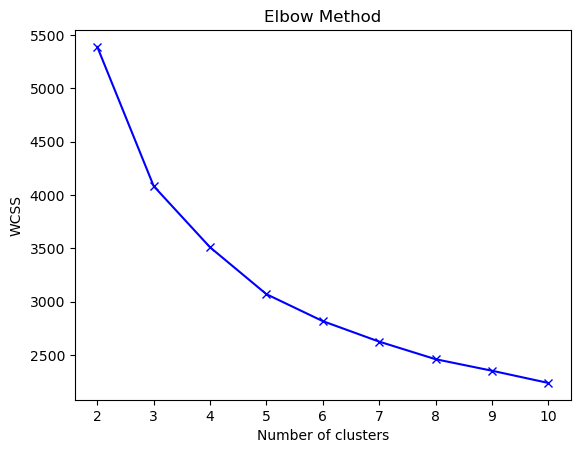

In [19]:
# kmodel.drop(columns='Cluster',inplace=True)
from sklearn.cluster import KMeans
kmodel = df_train.copy()
wcss = []
results = []
silhouette_avgs = []

for i in range(2, 11):  # Test different numbers of clusters
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(kmodel[st_columns1])  # X is your data
    wcss.append(kmeans.inertia_)
    silhouette = silhouette_score(kmodel[st_columns1], kmeans.labels_)
    silhouette_avgs.append(silhouette)
    results.append({'Number of Clusters': i, 'WCSS': kmeans.inertia_})
    
elbow_data = pd.DataFrame(results)
    
plt.plot(range(2, 11), wcss, 'bx-')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [20]:
elbow_data

Number of Clusters         WCSS
0                   2  5386.931210
1                   3  4083.019343
2                   4  3509.851652
3                   5  3070.681431
4                   6  2818.169295
5                   7  2626.274972
6                   8  2461.739701
7                   9  2353.814246
8                  10  2239.337235

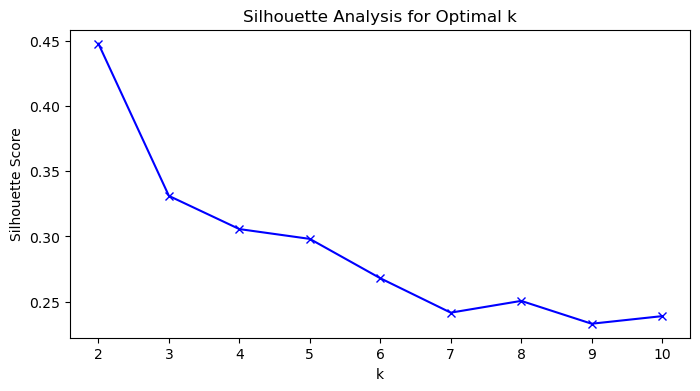

In [21]:
i = range(2, 11) 
plt.figure(figsize=(8, 4))
plt.plot(i, silhouette_avgs, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for Optimal k')
plt.show()

In [22]:
# kmodel = pd_df[pd_df['total_requirements_satisfied']>=2]
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(kmodel[st_columns1])
kmodel['Cluster'] = kmeans.labels_
kmodel_inference = kmodel[['reputation', 'reached',
       'questions', 'answers',
       'posts_edited', 'helpful_tags', 'votes_cast', 'member_since_in_months',
       'weighted_badge_score', 'QA_ratio','total_requirements_satisfied','Cluster']]

In [23]:
kmodel_inference.groupby('Cluster').mean().round(2)

reputation    reached  questions  answers  posts_edited  \
Cluster                                                            
0           4551.63  752837.66      83.61    55.38         23.97   
1             10.03     844.76       2.15     0.17          0.00   
2            179.13   23788.15      10.18     3.46          0.15   

         helpful_tags  votes_cast  member_since_in_months  \
Cluster                                                     
0                8.06      481.70                  119.39   
1                0.00        0.17                   27.29   
2                0.06       32.18                   67.97   

         weighted_badge_score  QA_ratio  total_requirements_satisfied  
Cluster                                                                
0                      140.91      1.94                          1.13  
1                        5.27      0.12                          1.12  
2                       22.32      0.73                          1.15

In [24]:
kmodel_inference.groupby('Cluster').mean().round(2)

reputation    reached  questions  answers  posts_edited  \
Cluster                                                            
0           4551.63  752837.66      83.61    55.38         23.97   
1             10.03     844.76       2.15     0.17          0.00   
2            179.13   23788.15      10.18     3.46          0.15   

         helpful_tags  votes_cast  member_since_in_months  \
Cluster                                                     
0                8.06      481.70                  119.39   
1                0.00        0.17                   27.29   
2                0.06       32.18                   67.97   

         weighted_badge_score  QA_ratio  total_requirements_satisfied  
Cluster                                                                
0                      140.91      1.94                          1.13  
1                        5.27      0.12                          1.12  
2                       22.32      0.73                          1.15

In [25]:
kmodel_inference.Cluster.value_counts().reset_index(name='No of Candidates')

Cluster  No of Candidates
0        1              1506
1        2              1479
2        0              1195

## VISUALIZING CLUSTERS

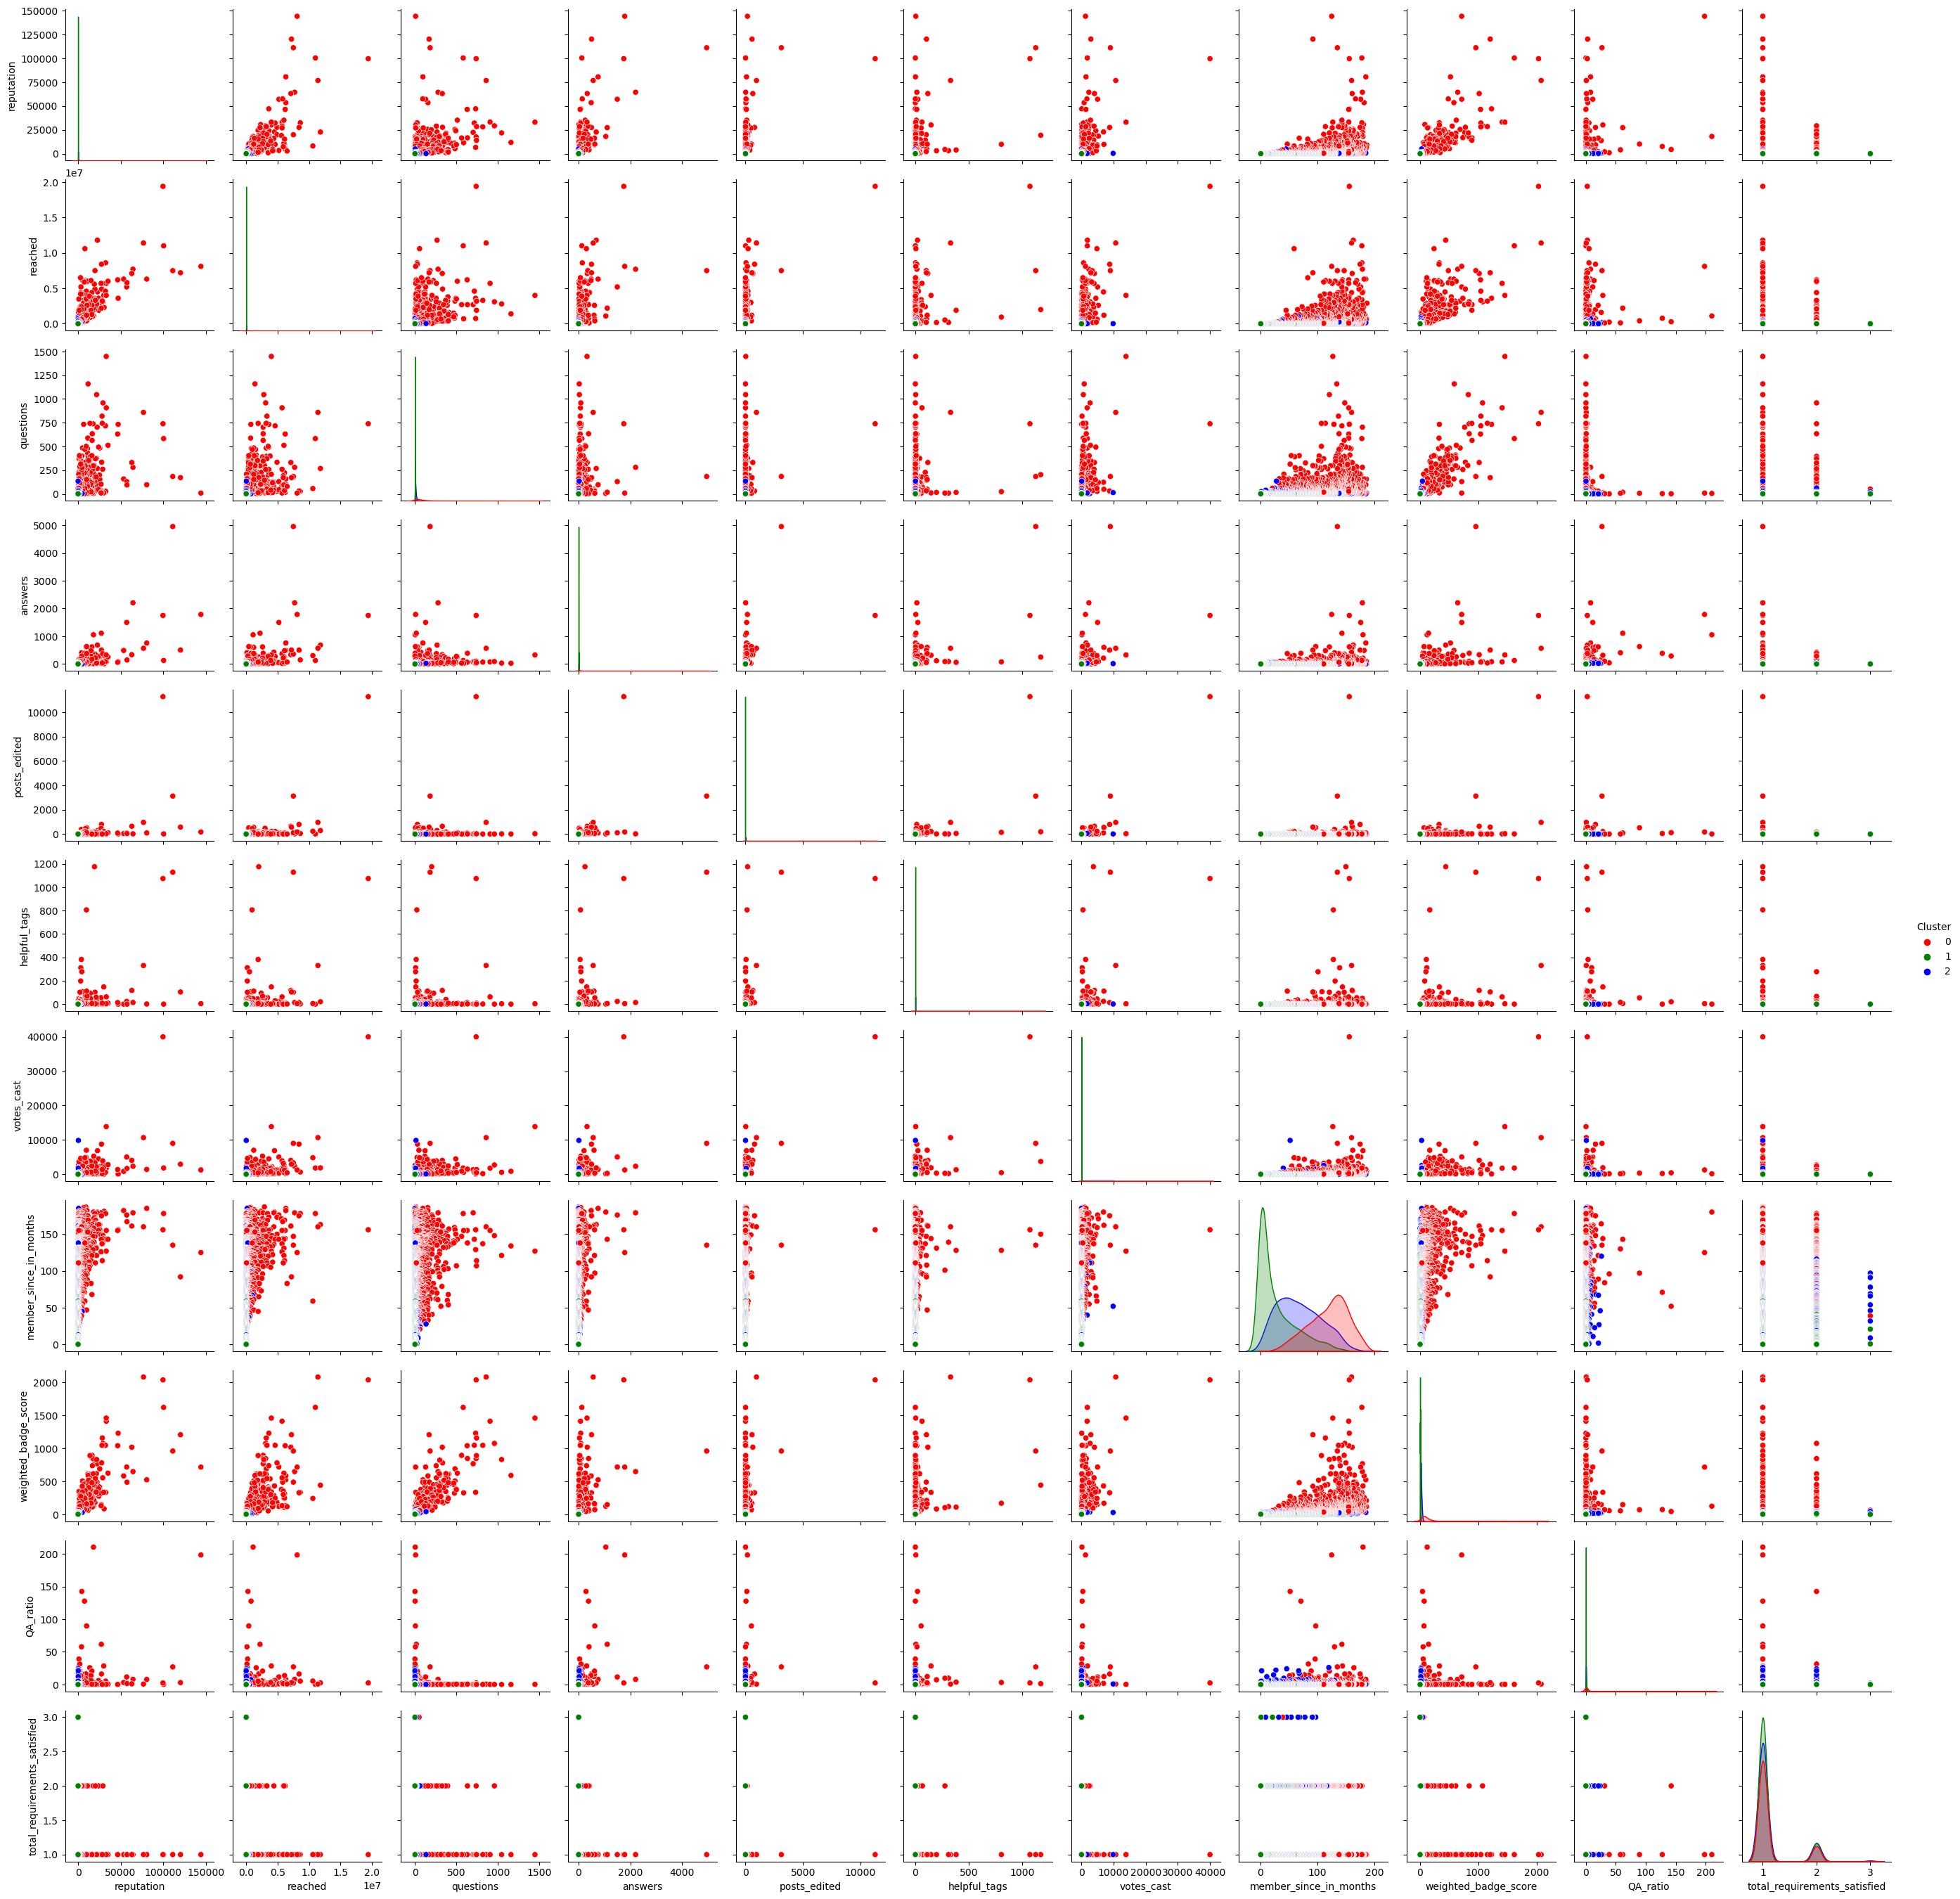

In [30]:
import seaborn as sns
palette = {0: "red", 1: "green", 2: "blue"} 
sns.pairplot(kmodel_inference, hue='Cluster', palette = palette)
plt.show()

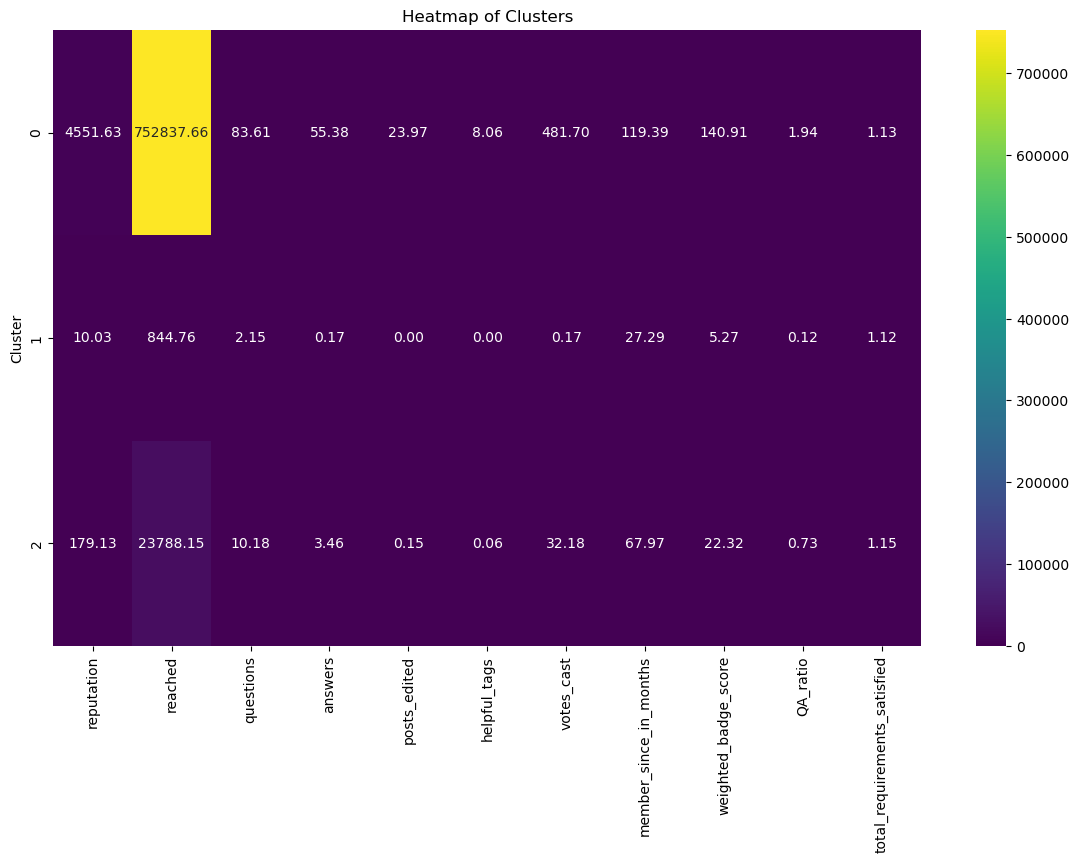

In [31]:
corr_matrix = kmodel_inference.groupby('Cluster').mean().round(2)
corr_matrix.sort_values(by='Cluster',inplace=True)
plt.figure(figsize=(14, 8))
ax = sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap = 'viridis')
plt.title('Heatmap of Clusters')
plt.show()
ax.figure.savefig("heatmap.png", dpi=300)

# TESTING

In [27]:
#Cleaning the data
df_test['name'] = df_test['name'].str.replace('\n','')
df_test['name'] = df_test['name'].str.strip()

#Null Value Imputation
df_test['job_role'].fillna('NA',inplace=True)
df_test['tags'].fillna('NA',inplace=True)
df_test['gold_badges'].fillna('NA',inplace=True)
df_test['silver_badges'].fillna('0',inplace=True)
df_test['bronze_badges'].fillna('0',inplace=True)
df_test['questions'].fillna('0',inplace=True)
df_test['answers'].fillna('0',inplace=True)
df_test['reputation'].fillna('0',inplace=True)
df_test['reached'].fillna('0',inplace=True)
df_test['posts_edited'].fillna('0',inplace=True)
df_test['votes_cast'].fillna('0',inplace=True)
df_test['helpful_tags'].fillna('0',inplace=True)

df_test[['silver_badges', 'bronze_badges','posts_edited', 'helpful_tags', 'votes_cast', 'reputation','reached', 'answers', 'questions']]=df_test[['silver_badges', 'bronze_badges','posts_edited', 'helpful_tags', 'votes_cast', 'reputation','reached', 'answers', 'questions']].apply(lambda x:x.str.replace(",",""))

# 2. Clean k and m values
df_test['reached'] = df_test['reached'].str.strip()

def convert_k_to_num(value):
    if isinstance(value, str) and value.lower().endswith('k'):
        return float(value[:-1]) * 1000
    elif isinstance(value, str) and value.lower().endswith('m'):
        return float(value[:-1]) * 1000000
    else:
        return float(value)
    
df_test['reached'] = df_test['reached'].apply(convert_k_to_num)

# 3. Cleaning Member_Since
def convert_to_months(s):
    # Initialize years, months, and days
    years, months, days = 0, 0, 0
    
    # Find and convert years, if present
    if 'year' in s:
        years = int(s.split('year')[0].strip())
    
    # Find and convert months, if present
    if 'month' in s:
        months = int(s.split('month')[0].split(',')[-1].strip())
    
    # Find and convert days, if present
    if 'day' in s:
        days = int(s.split('day')[0].split(',')[-1].strip())
    
    # Convert everything to months (approximation)
    total_months = years * 12 + months + days / 30  # Convert days to a fraction of a month
    return total_months

# Apply the conversion function to your 'Member_Since' column
df_test['member_since_in_months'] = df_test['member_since'].apply(convert_to_months)
df_test['member_since_in_months'] = df_test['member_since_in_months'].round(2)

#Type Casting
df_test[['silver_badges', 'bronze_badges','posts_edited', 'helpful_tags', 'votes_cast', 'reputation','reached', 'answers', 'questions']] = df_test[['silver_badges', 'bronze_badges','posts_edited', 'helpful_tags', 'votes_cast', 'reputation','reached', 'answers', 'questions']].apply(pd.to_numeric)

#Feature Engineering
df_test['weighted_badge_score'] = (3 * df_test['gold_badges']) + (2 * df_test['silver_badges']) + df_test['bronze_badges']
df_test['questions'] = np.where(df_test['questions']==0, 1, df_test['questions'])
df_test['QA_ratio'] = (df_test['answers']/df_test['questions']).round(2)

#dropping this because there's a weighted badge score
df_test.drop(columns=['gold_badges', 'silver_badges', 'bronze_badges'], inplace=True)

#Creating flags
df_test['Cloud_Services_Flag'] = np.where(df_test['tags'].str.contains('gcp|amazon|amazon-web-services|gcp|cloud|google-cloud-platform|azure'),1,0)
df_test['DevOps_Flag'] = np.where(df_test['tags'].str.contains('devops|jenkins|docker|kubernetes|ansible|terraform'),1,0)
df_test['Security_Flag'] = np.where(df_test['tags'].str.contains('security|oauth|ssl|encryption|cybersecurity|cyber-security'),1,0)
df_test['total_requirements_satisfied'] = df_test['Cloud_Services_Flag'] + df_test['DevOps_Flag'] + df_test['Security_Flag']

#Shortlisting Candidates with Valid Skill
df_test = df_test[df_test['total_requirements_satisfied']>=1]

#Transformations
df_test['reputation_st'],rep = st.boxcox(df_test['reputation']+1)
df_test['reached_st'],reach = st.boxcox(df_test['reached']+1)
df_test['questions_st'],ques = st.boxcox(df_test['questions']+1)
df_test['answers_st'] = 1/(df_test['answers']+1)
df_test['posts_edited_st'],post = st.boxcox(df_test['posts_edited']+1)
df_test['helpful_tags_st'],helpf = st.boxcox(df_test['helpful_tags']+1)
df_test['votes_cast_st'] = 1/(df_test['votes_cast']+1)
df_test['weighted_badge_score_st'],badge = st.boxcox(df_test['weighted_badge_score']+1)
df_test['QA_ratio_st'] = df_test['QA_ratio']**0.2

#Scaling with Robust Scaler
st_columns = [i for i in df_test.columns if i.endswith('_st')]
scaler = RobustScaler()
df_test[st_columns] = scaler.fit_transform(df_test[st_columns])
scaled2 = scaler.fit_transform(df_test[['member_since_in_months','total_requirements_satisfied']])
df_scaled2 = pd.DataFrame(scaled2, columns=['member_since_in_months_st','total_requirements_satisfied_st'], index=df_test.index)
df_test = pd.concat([df_test, df_scaled2], axis=1)
st_columns1 = [i for i in df_test.columns if i.endswith('_st')]

df_test['Cluster'] = kmeans.predict(df_test[st_columns1])
testing_inference = df_test[['reputation', 'reached',
       'questions', 'answers',
       'posts_edited', 'helpful_tags', 'votes_cast', 'member_since_in_months',
       'weighted_badge_score', 'QA_ratio','total_requirements_satisfied','Cluster']]

In [28]:
testing_inference.groupby('Cluster').mean().round(2)

reputation    reached  questions  answers  posts_edited  \
Cluster                                                            
0           3823.82  700824.15      73.54    43.67         13.96   
1             10.63    1179.88       2.28     0.19          0.00   
2            161.03   30465.81       9.76     3.12          0.09   

         helpful_tags  votes_cast  member_since_in_months  \
Cluster                                                     
0               13.83      432.22                  116.01   
1                0.01        0.23                   25.59   
2                0.09       22.39                   67.96   

         weighted_badge_score  QA_ratio  total_requirements_satisfied  
Cluster                                                                
0                      122.93      2.32                          1.15  
1                        5.54      0.11                          1.14  
2                       21.69      0.57                          1.14

In [29]:
testing_inference.Cluster.value_counts().reset_index(name='No of Candidates')

Cluster  No of Candidates
0        1               459
1        2               450
2        0               381

# Validation

In [30]:
from sklearn.metrics import silhouette_score

# Combine the training and testing data for a comprehensive silhouette analysis
combined = np.vstack((kmodel[st_columns1], df_test[st_columns1]))
clusters_combined = np.concatenate((kmodel['Cluster'], df_test['Cluster']))

# Compute the silhouette score
silhouette_avg = silhouette_score(combined, clusters_combined)
print('Combined Silhouette Score:', silhouette_avg)

Combined Silhouette Score: 0.3273469273763156


In [31]:
dir_path = './model_pickle_files'

# Define the complete file path including the name of the pickle file
file_path = os.path.join(dir_path, 'solutions-architect-model.pkl')

# Ensure the directory exists, create if it doesn't
os.makedirs(dir_path, exist_ok=True)

# Save the model as a pickle file
with open(file_path, 'wb') as file:
    pickle.dump(kmeans, file)

print(f"Model saved successfully at {file_path}")

Model saved successfully at ./model_pickle_files/solutions-architect-model.pkl


In [ ]:
df['devops_flag'] = df['tags'].apply(lambda x: 1 if any(tag in ['devops', 'ci/cd', 'jenkins', 'docker', 'kubernetes'] for tag in x) else 0)